In [112]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle
import matplotlib.pyplot as plt
#import cv2
#import plotly.graph_objs as go
import seaborn as sns
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#import mplcursors 
import random
import torch
from scipy.stats import pearsonr
from Utils import load_dict_from_csv

In [113]:
datasets_folder='/media/Blue2TB1'
datasets=['Jin_22','PAMI18','Fan_NOSSDAV_17']
dataset_colors = cm.rainbow(np.linspace(0, 1, len(datasets)))

## SITI Plots

In [114]:
def plot_SITI(dataset_name,datasets_folder, annotate_all=False, color='blue'):
    dataset_folder=os.path.join(datasets_folder,dataset_name)
    video_img_folder=os.path.join(dataset_folder, 'video_data')
    videos=os.listdir(video_img_folder)
    video_SIs=[]
    video_TIs=[]
    for video in videos:
        array_folder=os.path.join(video_img_folder,video)
        SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
        TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
        if np.mean(SI)>200:
            print(video)
            print(SI)
            print(np.mean(SI))
            return 0
        # Aggregating based on ITU-T P.910 (10/2023)
        video_SIs.append(np.mean(SI))
        video_TIs.append(np.mean(TI))
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(video_SIs, video_TIs, color=color, marker='o')

    if annotate_all:
        for i, video in enumerate(videos):
            plt.annotate(video, (video_SIs[i], video_TIs[i]))

    plt.title(f'Spatial and Temporal Information for {dataset_name}')
    plt.xlabel('Spatial Information (SI)')
    plt.ylabel('Temporal Information (TI)')
    plt.grid(True)
    
    plots_folder = os.path.join('Plots', 'SITI')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_plot.png')
    plt.savefig(plot_path)
    plt.show()
    

In [115]:
def plot_all_SITI(datasets_folder, datasets, annotate_all=False):
    plt.figure(figsize=(10, 6))
    colors = cm.rainbow(np.linspace(0, 1, len(datasets)))
    global_min_SI, global_max_SI = float('inf'), float('-inf')
    global_min_TI, global_max_TI = float('inf'), float('-inf')
    video_SIs={}
    video_TIs={}
    for idx, dataset_name in enumerate(datasets):
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        video_SIs[dataset_name] = []
        video_TIs[dataset_name] = []

        for video in videos:
            array_folder = os.path.join(video_img_folder, video)
            SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
            TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
            mean_SI, mean_TI=np.mean(SI),np.mean(TI)
            global_min_SI = min(global_min_SI, mean_SI)
            global_max_SI = max(global_max_SI, mean_SI)
            global_min_TI = min(global_min_TI, mean_TI)
            global_max_TI = max(global_max_TI, mean_TI)
            # Aggregating based on ITU-T P.910 (10/2023)
            
            video_SIs[dataset_name].append(mean_SI)
            video_TIs[dataset_name].append(mean_TI)
    
    for idx, dataset_name in enumerate(datasets):
        plt.figure(figsize=(12, 6))

        plt.scatter(video_SIs[dataset_name], video_TIs[dataset_name], color=colors[idx], label=dataset_name)

        if annotate_all:
            for i, video in enumerate(videos):
                plt.annotate(video, (video_SIs[i], video_TIs[i]), fontsize=8, color=colors[idx])

        plt.title(f'Spatial and Temporal Information for {dataset_name}')
        plt.xlabel('Spatial Information (SI)')
        plt.ylabel('Temporal Information (TI)')
        plt.legend()
        plt.xlim(0, global_max_SI+5)
        plt.ylim(0, global_max_TI+5)
        plt.grid(True)
        plots_folder = os.path.join('Plots', 'SITI')
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_plot.png')
        plt.savefig(plot_path)
        plt.show()

<Figure size 1000x600 with 0 Axes>

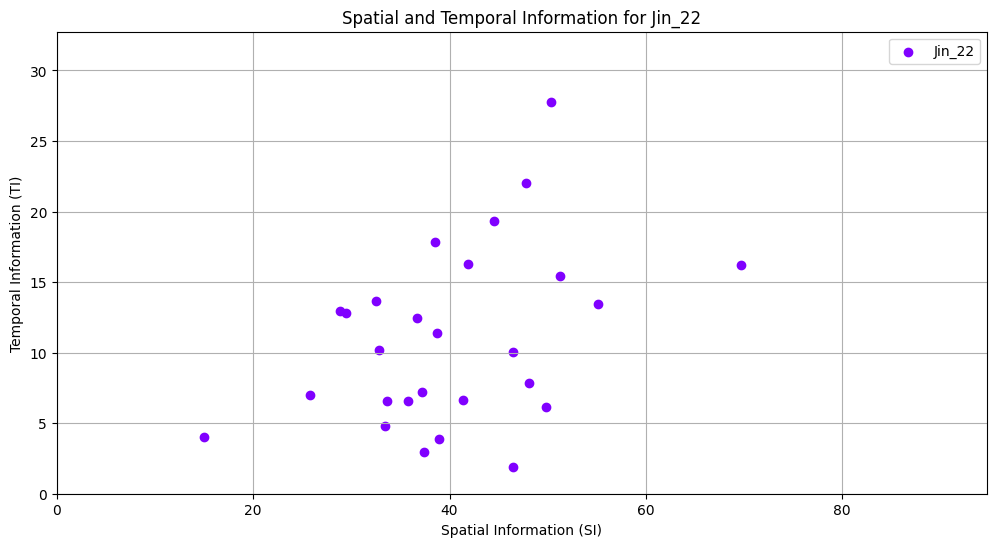

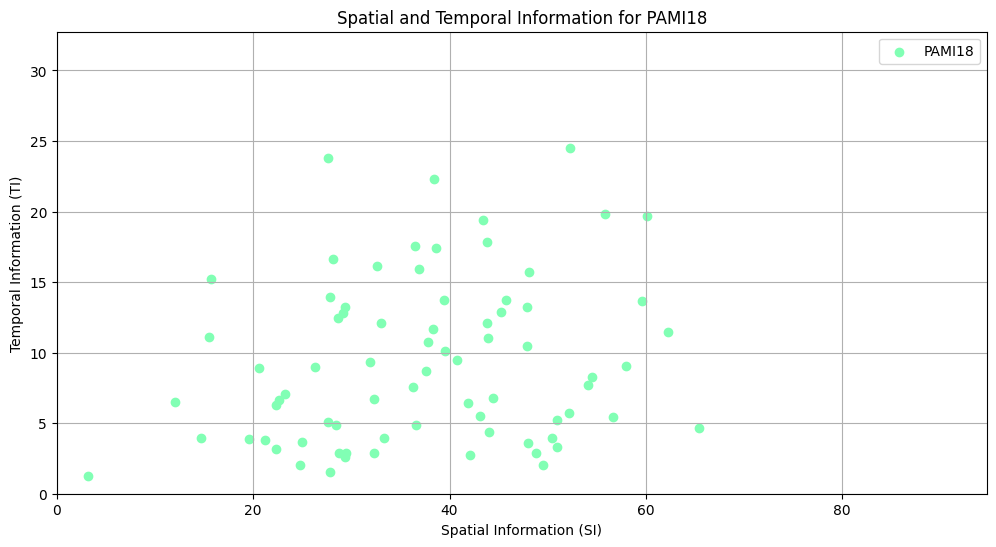

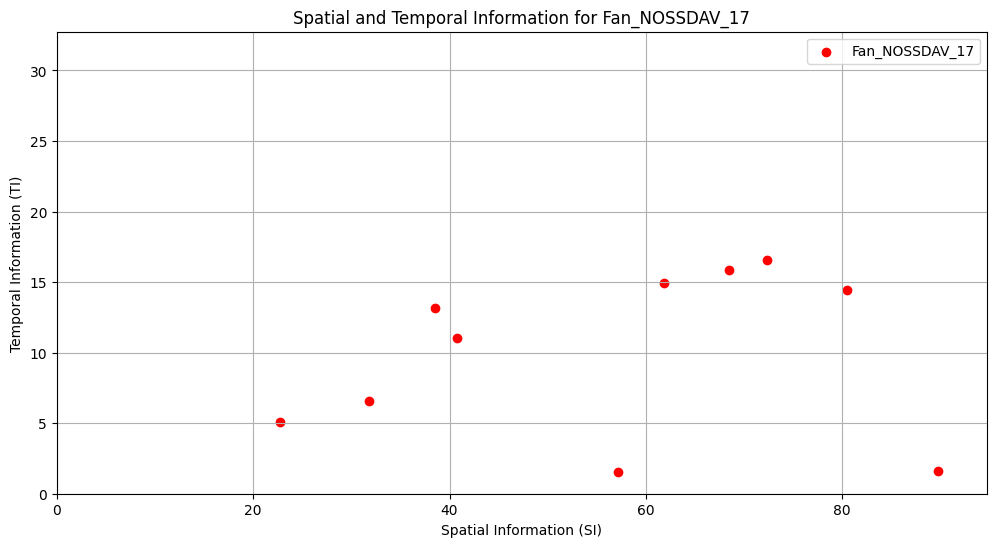

In [116]:
plot_all_SITI(datasets_folder,datasets)

## SITI and Entropy

In [117]:
def fetch_c_entropies(datasets_folder, dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(video_img_folder)
    entropies = {}
    
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        
        if os.path.exists(entropy_path):
            entropy = np.load(entropy_path)
            entropies[video] = entropy
            
    return entropies

In [118]:
def plot_mean_entropy_vs_SITI(datasets_folder, dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)

    data_path = os.path.join(dataset_folder, 'video_data')
    
    videos = os.listdir(data_path)
    mean_SIs = []
    mean_TIs = []
    mean_entropies = []
    
    for video in videos:
        # Load SI and TI values
        array_folder = os.path.join(data_path, video)
        SI_path = os.path.join(array_folder, 'video_SI.npy')
        TI_path = os.path.join(array_folder, 'video_TI.npy')
        
        if os.path.exists(SI_path) and os.path.exists(TI_path):
            SI = np.load(SI_path)
            TI = np.load(TI_path)
            mean_SIs.append(np.mean(SI))
            mean_TIs.append(np.mean(TI))
        
        # Load content entropy values
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        
        if os.path.exists(entropy_path):
            entropy = np.load(entropy_path)
            mean_entropies.append(np.mean(entropy))
    
    # Determine vmin and vmax for the colormap to handle outliers
    vmin = np.percentile(mean_entropies, 5)
    vmax = np.percentile(mean_entropies, 95)
    
    # Plot mean SI vs mean TI with content entropy as colormap
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mean_SIs, mean_TIs, c=mean_entropies, cmap='coolwarm', marker='o', vmin=vmin, vmax=vmax)
    
    plt.title(f'Mean TI vs Mean SI with Content Entropy for {dataset}')
    plt.xlabel('Mean Spatial Information (SI)')
    plt.ylabel('Mean Temporal Information (TI)')
    colorbar = plt.colorbar(scatter, label='Mean Content Entropy')
    plt.grid(True)
    plt.tight_layout()
    plots_folder = os.path.join('Plots', 'SITI_entropy')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_SITI_with_entropy_plot.png')
    #plt.savefig(plot_path)
    plt.show()

In [119]:
def plot_mean_entropy_vs_SITI_alldatasets(datasets_folder, datasets,fontsize=12,markersize=5):
    global_min_SI, global_max_SI = float('inf'), float('-inf')
    global_min_TI, global_max_TI = float('inf'), float('-inf')
    video_SIs={}
    video_TIs={}
    video_CEs={}
    for idx, dataset_name in enumerate(datasets):
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        video_SIs[dataset_name] = []
        video_TIs[dataset_name] = []
        video_CEs[dataset_name]=[]
        
        
        for video in videos:
            array_folder = os.path.join(video_img_folder, video)
            SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
            TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
            CE=np.load(os.path.join(array_folder,f'{video}_content_entropy.npy'))
            mean_SI, mean_TI, mean_CE=np.mean(SI),np.mean(TI),np.mean(CE)
            global_min_SI = min(global_min_SI, mean_SI)
            global_max_SI = max(global_max_SI, mean_SI)
            global_min_TI = min(global_min_TI, mean_TI)
            global_max_TI = max(global_max_TI, mean_TI)
            # Aggregating based on ITU-T P.910 (10/2023)
            
            video_SIs[dataset_name].append(mean_SI)
            video_TIs[dataset_name].append(mean_TI)
            video_CEs[dataset_name].append(mean_CE)
    
    for idx, dataset_name in enumerate(datasets):
        print(dataset_name)
        plt.figure(figsize=(10,7))
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        
        vmin = np.percentile(video_CEs[dataset_name], 5)
        vmax = np.percentile(video_CEs[dataset_name], 95)
        #scatter = plt.scatter(mean_SIs, mean_TIs, c=mean_entropies, cmap='coolwarm', marker='o', vmin=vmin, vmax=vmax)
        scatter=plt.scatter(video_SIs[dataset_name], video_TIs[dataset_name], c=video_CEs[dataset_name],
                            cmap='coolwarm', marker='o', s=markersize,
                            vmin=vmin, vmax=vmax)
        """ for i, video in enumerate(videos):
            plt.annotate(video, (video_SIs[dataset_name][i], video_TIs[dataset_name][i]), 
                         fontsize=fontsize-6, ha='right', va='bottom') """
        
        #plt.title(f'Mean TI vs Mean SI with Content Entropy for {dataset_name}')
        plt.xlabel('Mean Spatial Information (SI)',fontsize=fontsize)
        plt.ylabel('Mean Temporal Information (TI)',fontsize=fontsize)
        colorbar = plt.colorbar(scatter)   
        colorbar.set_label(label='Mean Entropy of Saliency Maps', size=fontsize-2)     
        #plt.legend()
        plt.xlim(0, global_max_SI+5)
        plt.ylim(0, global_max_TI+5)
        plt.xticks(fontsize=fontsize-7)
        plt.yticks(fontsize=fontsize-7)
        plt.grid(True)
        plt.tight_layout()
        plots_folder = os.path.join('Plots', 'SITI_entropy')
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_with_entropy_plot.png')
        plt.savefig(plot_path)
        plt.show()    

In [120]:
def plot_actual_entropy_vs_SITI_alldatasets(datasets_folder, datasets,fontsize=12,markersize=5):
    global_min_SI, global_max_SI = float('inf'), float('-inf')
    global_min_TI, global_max_TI = float('inf'), float('-inf')
    video_SIs={}
    video_TIs={}
    video_AEs={}
    
    for idx, dataset_name in enumerate(datasets):
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        video_SIs[dataset_name] = []
        video_TIs[dataset_name] = []
        video_AEs[dataset_name]=[]
        
        
        for video in videos:
            array_folder = os.path.join(video_img_folder, video)
            SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
            TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
            AE=np.load(os.path.join(array_folder,f'{video}_AEs.npy'))
            
            mean_SI, mean_TI, mean_AE=np.mean(SI),np.mean(TI), np.mean(AE)
            global_min_SI = min(global_min_SI, mean_SI)
            global_max_SI = max(global_max_SI, mean_SI)
            global_min_TI = min(global_min_TI, mean_TI)
            global_max_TI = max(global_max_TI, mean_TI)
            # Aggregating based on ITU-T P.910 (10/2023)
            
            video_SIs[dataset_name].append(mean_SI)
            video_TIs[dataset_name].append(mean_TI)
            video_AEs[dataset_name].append(mean_AE)
    
    for idx, dataset_name in enumerate(datasets):
        plt.figure(figsize=(10,7))
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        
        vmin = np.percentile(video_AEs[dataset_name], 5)
        vmax = np.percentile(video_AEs[dataset_name], 95)
        #scatter = plt.scatter(mean_SIs, mean_TIs, c=mean_entropies, cmap='coolwarm', marker='o', vmin=vmin, vmax=vmax)
        scatter=plt.scatter(video_SIs[dataset_name], video_TIs[dataset_name], c=video_AEs[dataset_name],
                            cmap='coolwarm', marker='o', s=markersize,
                            vmin=vmin, vmax=vmax)
        """ for i, video in enumerate(videos):
            plt.annotate(video, (video_SIs[dataset_name][i], video_TIs[dataset_name][i]), 
                         fontsize=fontsize-6, ha='right', va='bottom') """
        
        plt.title(f'Mean TI vs Mean SI with Actual Entropy for {dataset_name}')
        plt.xlabel('Mean Spatial Information (SI)',fontsize=fontsize)
        plt.ylabel('Mean Temporal Information (TI)',fontsize=fontsize)
        colorbar = plt.colorbar(scatter)   
        colorbar.set_label(label='Actual Entropy', size=fontsize-2)     
        #plt.legend()
        plt.xlim(0, global_max_SI+5)
        plt.ylim(0, global_max_TI+5)
        plt.xticks(fontsize=fontsize-7)
        plt.yticks(fontsize=fontsize-7)
        plt.grid(True)
        plt.tight_layout()
        plots_folder = os.path.join('Plots', 'SITI_actual_entropy')
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_with_actual_entropy_plot.png')
        #plt.savefig(plot_path)
        plt.show()    

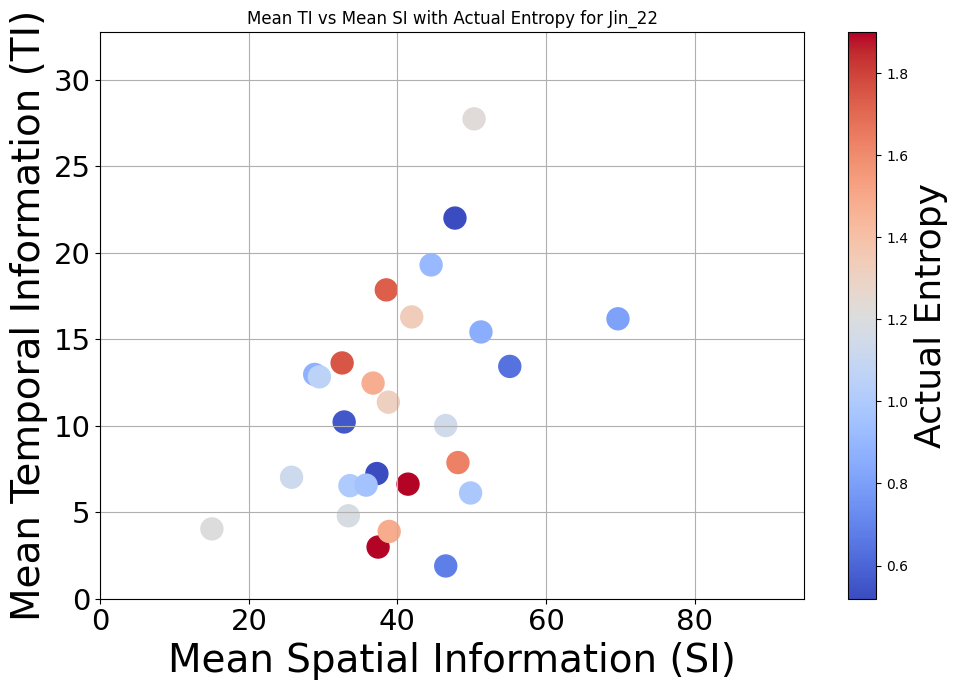

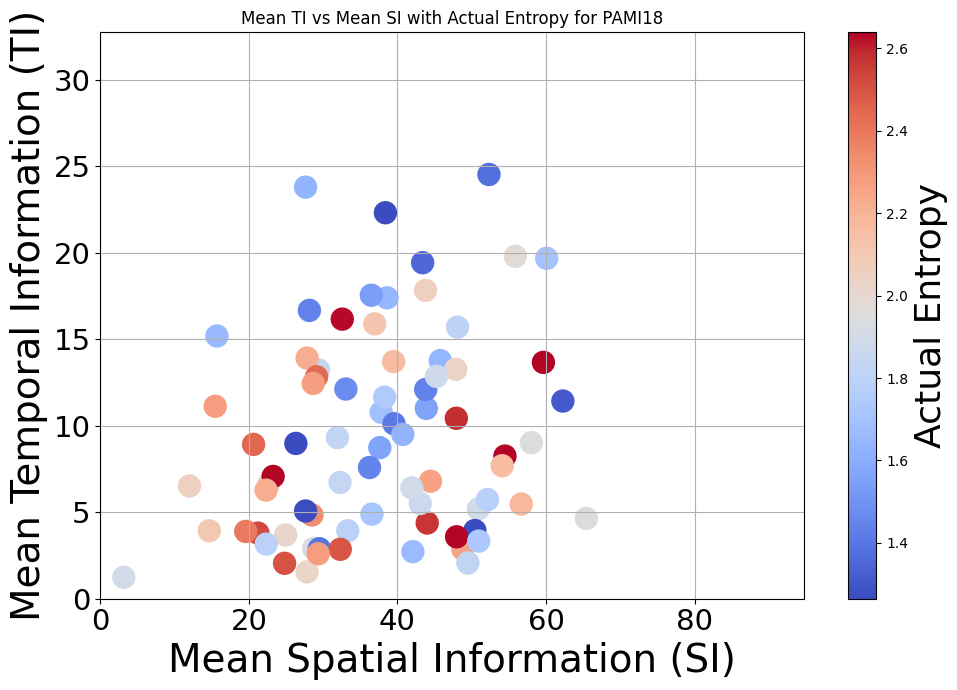

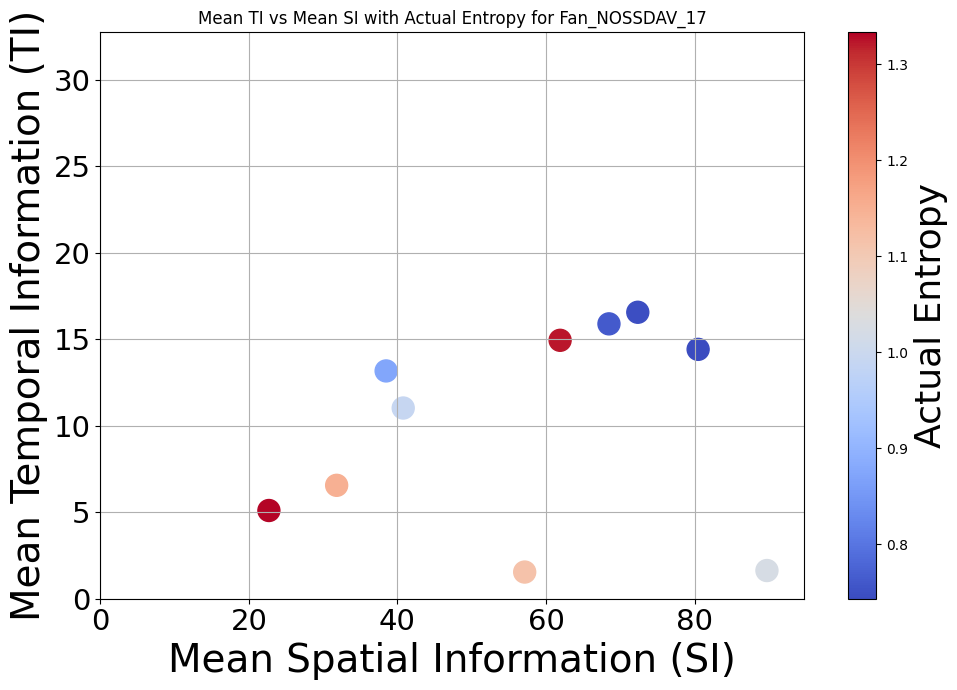

In [121]:
plot_actual_entropy_vs_SITI_alldatasets(datasets_folder,datasets,fontsize=28,markersize=250)

Jin_22


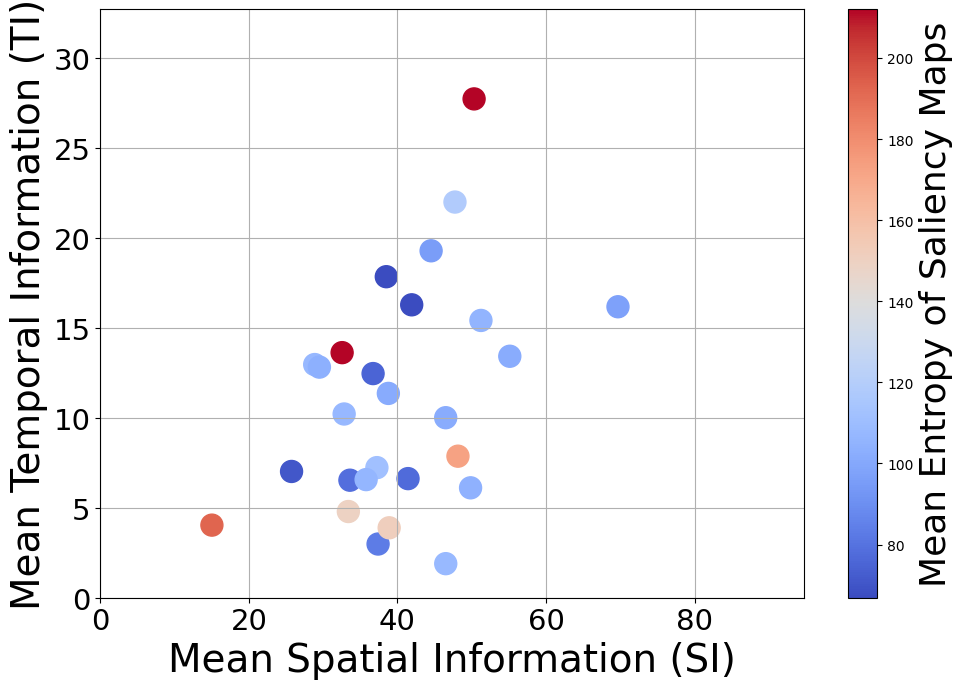

PAMI18


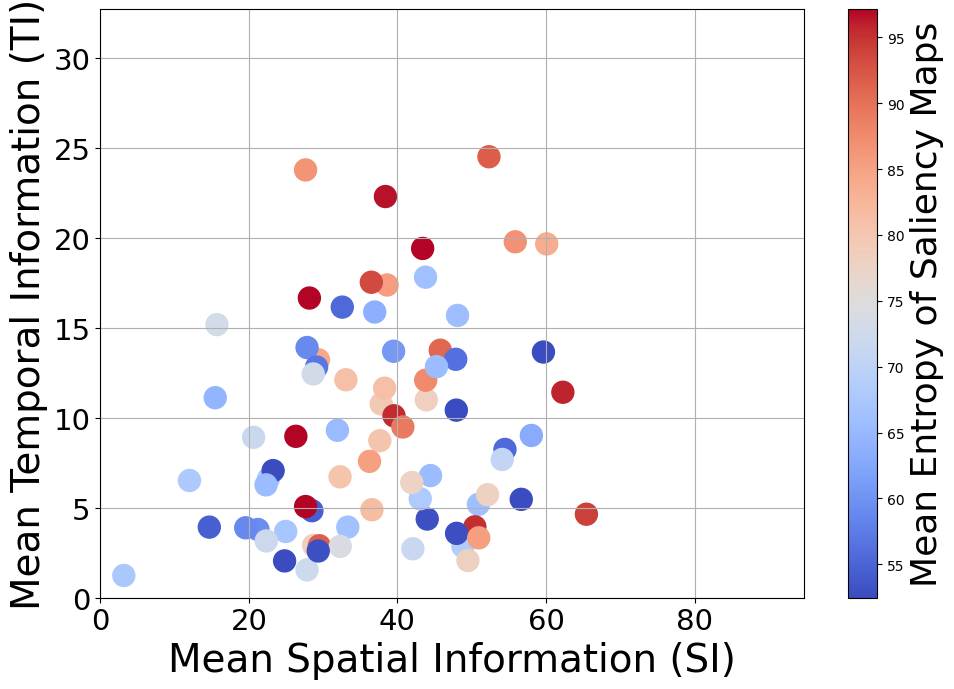

Fan_NOSSDAV_17


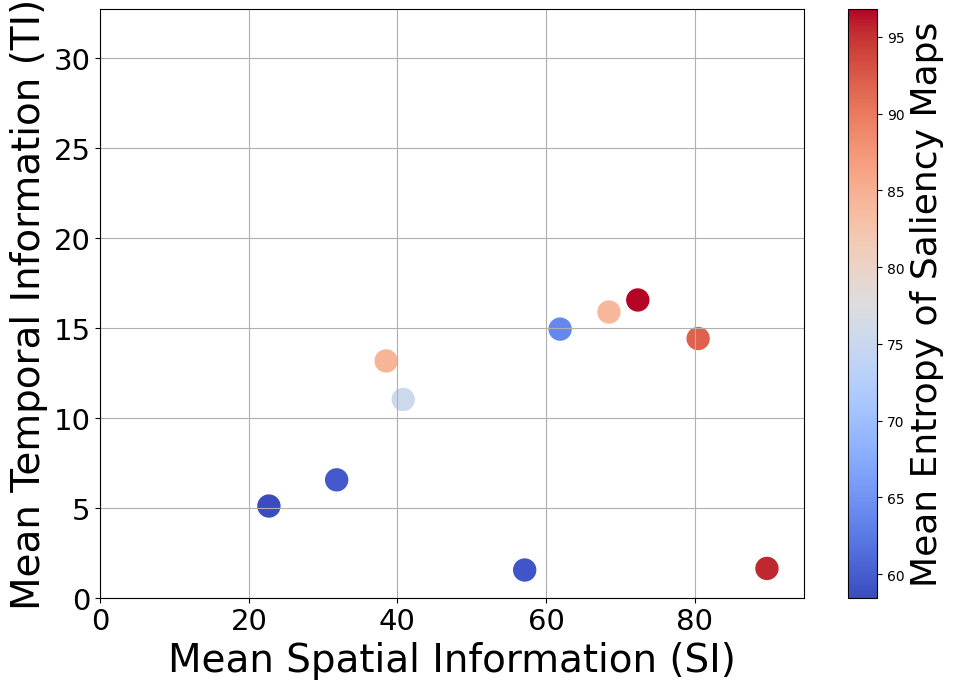

In [122]:
plot_mean_entropy_vs_SITI_alldatasets(datasets_folder,datasets,fontsize=28,markersize=250)

## Entropy v Entropy

In [123]:
def fetch_entropies(datasets_folder,dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(data_path)
    entropies={}
    aes={}
    IEs={}
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        ae_path=os.path.join(data_path,video, f'{video}_AEs.npy')
        IE_path=os.path.join(data_path, video, f'{video}_IEs.npy')
        entropy=np.load(entropy_path)
        ae=np.load(ae_path)
        ie=np.load(IE_path)
        entropies[video]=entropy
        aes[video]=ae
        IEs[video]=ie
    return entropies,aes,IEs

In [124]:
def plot_mean_AEs_vs_entropy(entropies, aes,dataset,color='blue',fontsize=12,markersize=50):
    print(dataset)
    mean_entropies = []
    mean_AEs = []
    videos=list(entropies.keys())
    for video in entropies:
        if np.mean(entropies[video])>150:
            videos.remove(video)
            continue
        mean_AE=np.mean(aes[video])
        mean_CE=np.mean(entropies[video])
        if video=='video_22' or video=='video_13' or video=='VRBasketball':
            print(video," : ", mean_AE, " : ", mean_CE)
        mean_entropies.append(mean_CE)
        mean_AEs.append(mean_AE)
        
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_AEs, mean_entropies, color=color, marker='o',s=markersize)
    for i, video in enumerate(videos):
        plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=fontsize-6, ha='right', va='bottom')
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean Actual Entropy',fontsize=fontsize)
    plt.ylabel('Mean Entropy of Saliency of Maps',fontsize=fontsize)
    plt.xticks(fontsize=fontsize-7)
    plt.yticks(fontsize=fontsize-7)
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Entropies')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_contententropy_vs_AE.png')
    plt.savefig(plot_path)
    plt.show()

In [125]:
def plot_mean_AEs_vs_entropy_all_datasets(datasets_folder,datasets,color,dataset_names,fontsize=12,markersize=50):
    global_min_AE, global_max_AE = float('inf'), float('-inf')
    global_min_CE, global_max_CE = float('inf'), float('-inf')
    video_AEs={}
    video_CEs={}
    for idx,dataset in enumerate(datasets):
        ces,aes,_=fetch_entropies(datasets_folder,dataset)
        mean_CEs = []
        mean_AEs = []
        for video in ces:
            if np.mean(ces[video])>150:
                continue
            mean_CE=np.mean(ces[video])
            mean_AE=np.mean(aes[video])
            global_min_AE = min(global_min_AE, mean_AE)
            global_max_AE = max(global_max_AE, mean_AE)
            global_min_CE = min(global_min_CE, mean_CE)
            global_max_CE = max(global_max_CE, mean_CE)
            mean_CEs.append(mean_CE)
            mean_AEs.append(mean_AE)
        video_AEs[dataset]=mean_AEs
        video_CEs[dataset]=mean_CEs
    
    plt.figure(figsize=(8, 6))
    for idx, dataset in enumerate(datasets):
        
        
        plt.scatter(video_AEs[dataset], video_CEs[dataset], color=color[idx], marker='o',label=dataset_names[idx],s=markersize)
        #for i, video in enumerate(entropies):
        #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean Actual Entropy',fontsize=fontsize)
    plt.ylabel('Mean Entropy of Saliency of Maps',fontsize=fontsize)
    plt.ylim(global_min_CE-2, global_max_CE+2)
    plt.xlim(global_min_AE-0.1, global_max_AE + 0.1)
    plt.xticks(fontsize=fontsize-4)
    plt.yticks(fontsize=fontsize-4)
    plt.legend()
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Entropies')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'all_datasets_contententropy_vs_AE.png')
    plt.savefig(plot_path)
    plt.show()
    

Jin_22
video_13  :  0.3788077962713763  :  118.18537117167509
video_22  :  2.2602501542199565  :  83.03465360452248


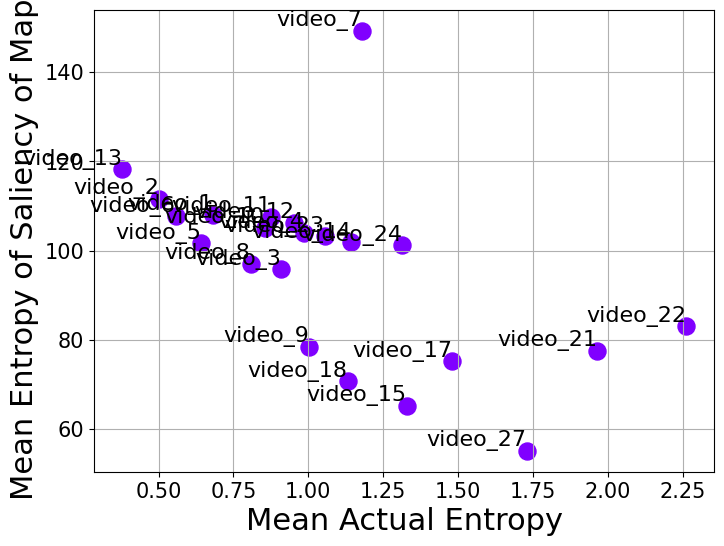

PAMI18
VRBasketball  :  2.8948511359592204  :  55.56339833620951


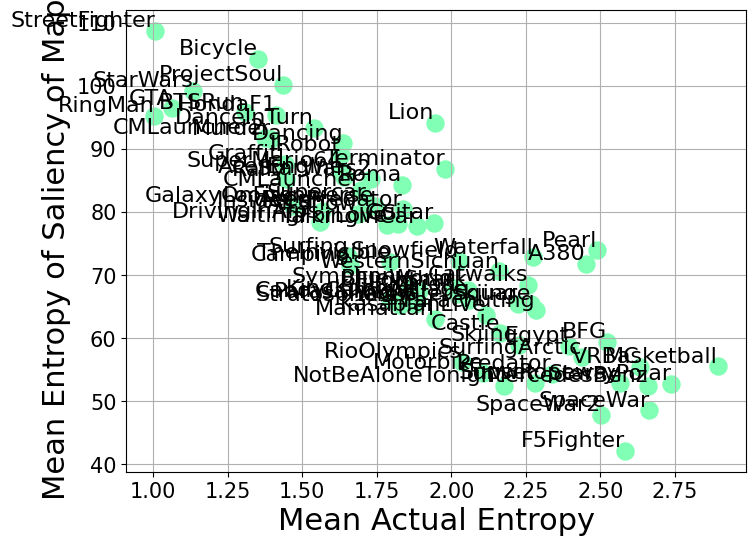

Fan_NOSSDAV_17


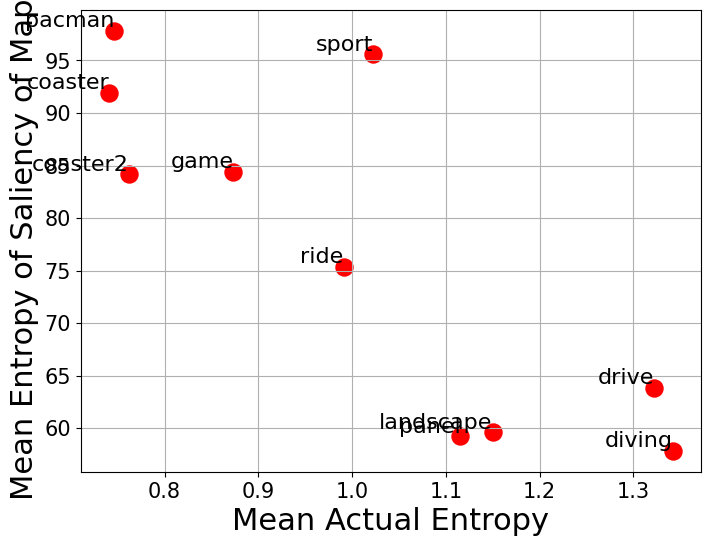

In [126]:
for idx,dataset in enumerate(datasets):
    c_entropies,aes,IEs=fetch_entropies(datasets_folder,dataset)
    plot_mean_AEs_vs_entropy(c_entropies, aes, dataset,color=dataset_colors[idx],fontsize=22,markersize=150)

In [127]:
dataset_names=['MM22','PAMI18','NOSSDAV17']

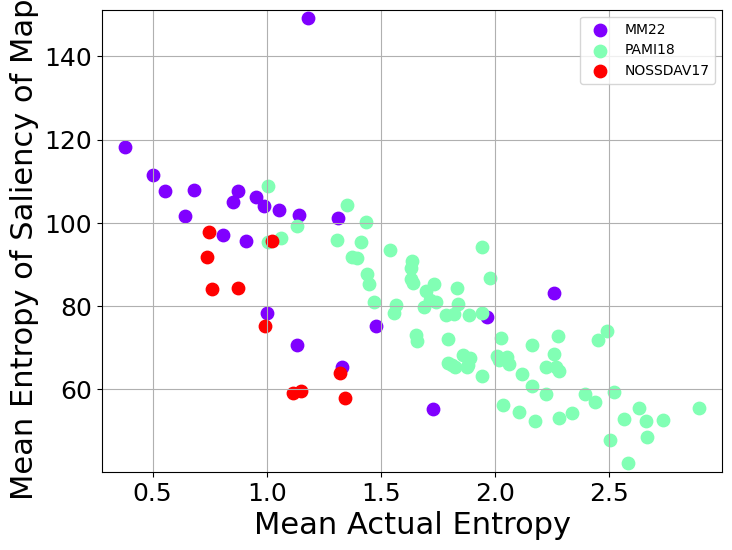

In [128]:
plot_mean_AEs_vs_entropy_all_datasets(datasets_folder,datasets,dataset_colors,dataset_names=dataset_names,fontsize=22,markersize=80)

## Train test

In [129]:
def plot_train_test(datasets_folder,dataset, ces,aes,fontsize=12,markersize=50):
    dataset_dir=os.path.join(datasets_folder,dataset)
    vid_data_dir=os.path.join(dataset_dir,'video_data')
    split_path=os.path.join(dataset,'splits','test_vids')
    test_vids=load_dict_from_csv(split_path,columns=['video'])
    test_vids=[vid[0] for vid in test_vids]
    all_vids=os.listdir(vid_data_dir)
    train_vids=list(set(all_vids)-set(test_vids))
    
    test_AEs=[]
    test_CEs=[]
    
    for video in test_vids:
        test_CEs.append(np.mean(ces[video]))
        test_AEs.append(np.mean(aes[video]))
     
    train_AEs=[]
    train_CEs=[]    
    for video in train_vids:
        train_CEs.append(np.mean(ces[video]))
        train_AEs.append(np.mean(aes[video]))
        
    plt.figure(figsize=(8, 6))
    plt.scatter(train_AEs, train_CEs, color='blue', marker='o', label='Training Videos',s=markersize)
    plt.scatter(test_AEs, test_CEs, color='red', marker='o', label='Testing Videos',s=markersize)
    # Adding legend
    plt.legend(loc='best', fontsize=fontsize-3)
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean Actual Entropy',fontsize=fontsize)
    plt.ylabel('Mean Content Entropy',fontsize=fontsize)
    plt.xticks(fontsize=fontsize-7)
    plt.yticks(fontsize=fontsize-7)
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Splits')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_train_test_split.png')
    plt.savefig(plot_path)
    plt.show()

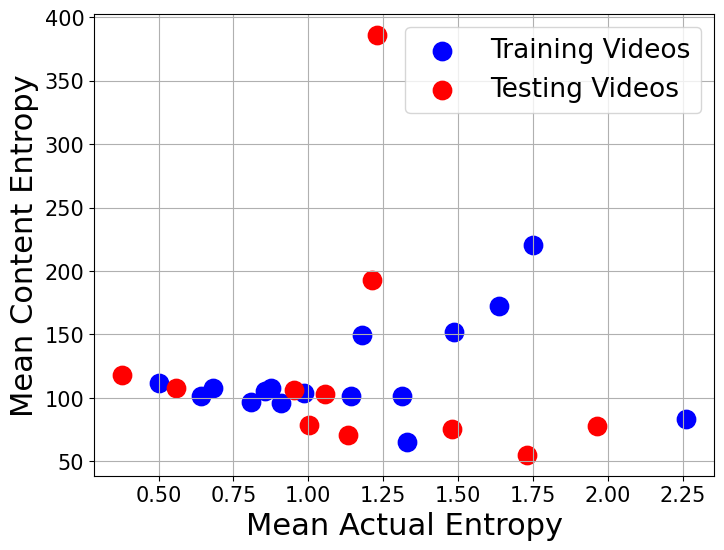

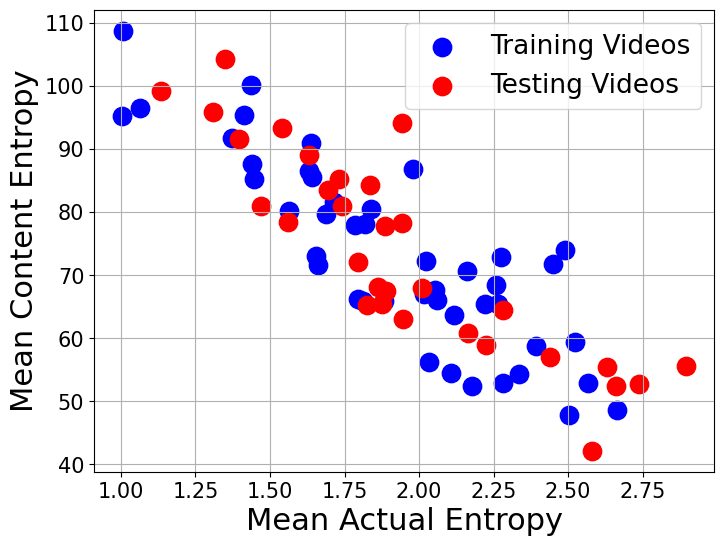

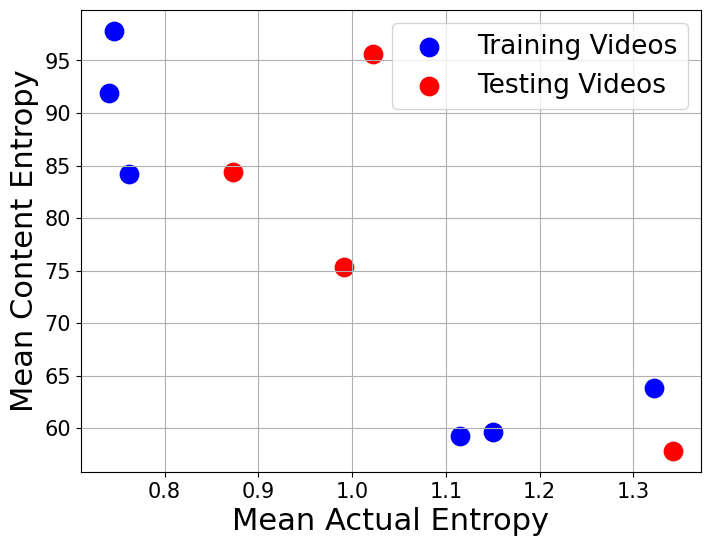

In [130]:
used_datasets=['Jin_22', 'PAMI18', 'Fan_NOSSDAV_17']
for idx,dataset in enumerate(used_datasets):
    ces,aes,IEs=fetch_entropies(datasets_folder,dataset)
    plot_train_test(datasets_folder,dataset,ces,aes,fontsize=22,markersize=175)

In [131]:
datasets

['Jin_22', 'PAMI18', 'Fan_NOSSDAV_17']

In [133]:
def get_model_name(model):
    model=model.split('_')
    if model[0]=='pos':
        if model[2] in ['augmented','weighted']:
            model_name=f'pos_{model[2]}'
        else:
            model_name='pos_only'
    else:
        model_name=model[0]
    if model_name=='DVMS':
        model_name=model_name+'_'+model[-2][1:]
        
    return model_name

## Test Plots for 5sec

In [199]:
model_colors = {
    'pos_only': 'blue',
    'TRACK': 'orange',
    'DVMS_5': 'gold',       
    'DVMS_2': 'magenta',
    'VPT360': 'red',
    'pos_augmented': 'purple',
    'pos_weighted': 'green', 
    'AMH': 'brown',
    'ALSTM': 'cyan',
    'ALSTM-E': 'teal'         
}

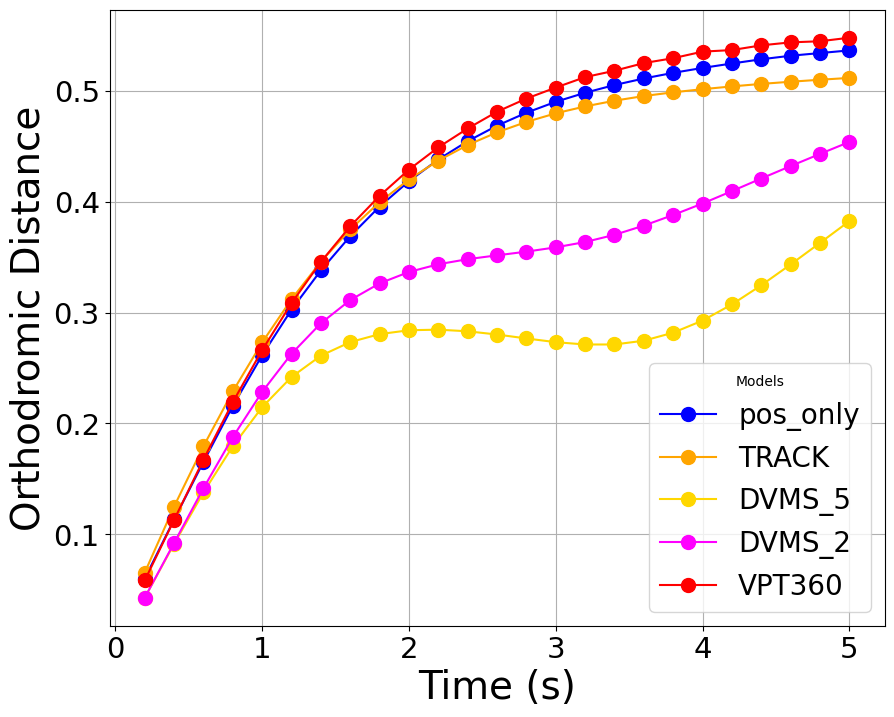

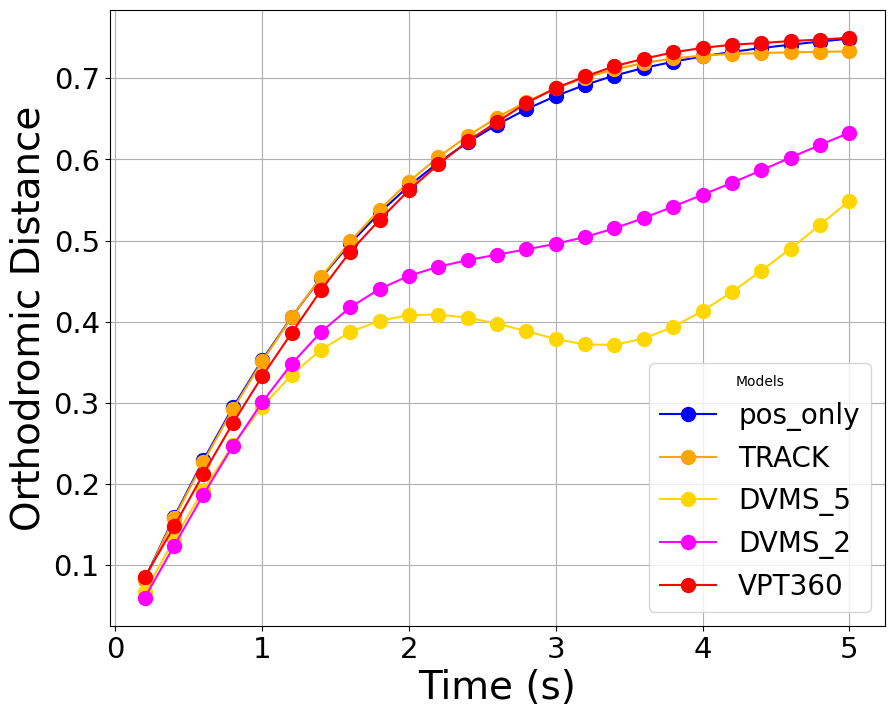

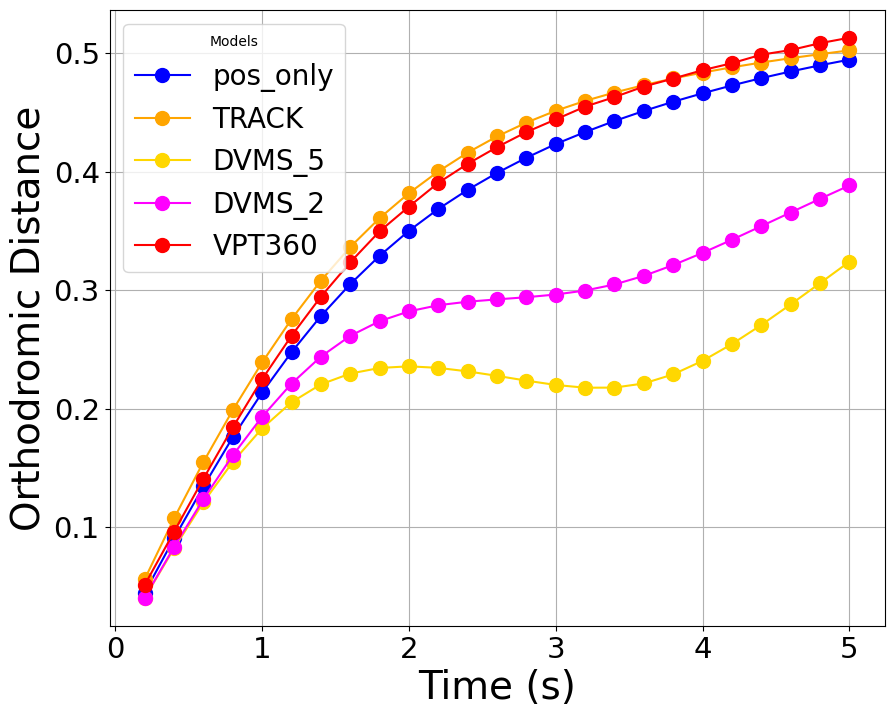

In [200]:
plot_paths='TestPlots'
datasets=os.listdir(plot_paths)
dataset_names=['NOSSDAV17','MM22','PAMI18']
fontsize=28
markersize=10
for idx,dataset in enumerate(datasets):
    paths=os.path.join(plot_paths,dataset)
    models=os.listdir(paths)
    model_dist_values = {}
    model_names=[get_model_name(model) for model in models]
    for model,model_name in zip(models,model_names):
        model_path=os.path.join(paths,model)
        dist_values_path=os.path.join(model_path,'orth_dist_values.npy')
        if os.path.exists(dist_values_path):
            # Load the dist_values from the file
            dist_values = np.load(dist_values_path)
            # Store dist_values in the dictionary with model name as key
            model_dist_values[model_name] = dist_values
        else:
            print(f"File {dist_values_path} does not exist.")

    reordered=[
               'pos_only',
               'TRACK',
               'DVMS_5',
               'DVMS_2',
               'VPT360',
               #'pos_augmented',
               #'pos_weighted',
               #'AMH',
               #'ALSTM',
               #'ALSTM-E'
               ]
    reordered_values={key: model_dist_values[key] for key in reordered}
    
    if reordered_values:
        # Generate the timestamps based on 5fps
        timestamps = np.arange(0.2, 5.1, 0.2)  # Adjust according to your timestamp range and fps
        
        # Plotting
        plt.figure(figsize=(10, 8))
        # Plot each model's dist_values with a label
        for model_name, dist_values in reordered_values.items():
            #model_name=get_model_name(model)
            color = model_colors.get(model_name, 'black')
            plt.plot(timestamps, dist_values, marker='o', linestyle='-', label=model_name,markersize=markersize, color=color)
        
        #plt.title(f'Dataset: {dataset_names[idx]} - Orthodromic Distance Across Models')
        plt.xlabel('Time (s)',fontsize=fontsize)
        plt.ylabel('Orthodromic Distance',fontsize=fontsize)
        plt.legend(title='Models',fontsize=fontsize-8)
        plt.xticks(fontsize=fontsize-7)
        plt.yticks(fontsize=fontsize-7)
        
        plt.grid(True)
        plots_folder = os.path.join('Plots', 'Model_Performances')
        os.makedirs(plots_folder, exist_ok=True)
        # Save plot to the dataset path
        plot_file = os.path.join(plots_folder, f'{dataset}_model_dist_values.png')
        plt.savefig(plot_file)
        plt.show()
        plt.close()
        
        #print(f"Plot saved at: {plot_file}")
    else:
        print(f"No dist_values found for dataset: {dataset}")

In [138]:
""" plot_paths='New_User_TestPlots'
datasets=os.listdir(plot_paths)
dataset_names=['PAMI18','NOSSDAV17','MM22']
fontsize=22
for idx,dataset in enumerate(datasets):
    paths=os.path.join(plot_paths,dataset)
    models=os.listdir(paths)
    model_dist_values = {}
    model_names=[get_model_name(model) for model in models]
    for model,model_name in zip(models,model_names):
        model_path=os.path.join(paths,model)
        dist_values_path=os.path.join(model_path,'orth_dist_values.npy')
        if os.path.exists(dist_values_path):
            # Load the dist_values from the file
            dist_values = np.load(dist_values_path)
            
            # Store dist_values in the dictionary with model name as key
            model_dist_values[model_name] = dist_values
        else:
            print(f"File {dist_values_path} does not exist.")

    reordered=['pos_only','TRACK','DVMS_K=2','DVMS_K=5']
    reordered_values={key: model_dist_values[key] for key in reordered}
    
    if reordered_values:
        # Generate the timestamps based on 5fps
        timestamps = np.arange(0.2, 5.1, 0.2)  # Adjust according to your timestamp range and fps
        
        # Plotting
        plt.figure(figsize=(12, 8))
        # Plot each model's dist_values with a label
        for model_name, dist_values in reordered_values.items():
            #model_name=get_model_name(model)
            plt.plot(timestamps, dist_values, marker='o', linestyle='-', label=model_name, markersize=7)
        
        #plt.title(f'Dataset: {dataset_names[idx]} - Orthodromic Distance Across Models')
        plt.xlabel('Time (s)',fontsize=fontsize)
        plt.ylabel('Orthodromic Distance',fontsize=fontsize)
        plt.legend(title='Models',fontsize=fontsize-7)
        plt.grid(True)
        plots_folder = os.path.join('Plots', 'Model_Performances')
        os.makedirs(plots_folder, exist_ok=True)
        # Save plot to the dataset path
        plot_file = os.path.join(plots_folder, f'{dataset}_model_dist_values_new_user.png')
        plt.xticks(fontsize=fontsize-7)
        plt.yticks(fontsize=fontsize-7)
        #plt.savefig(plot_file)
        plt.show()
        plt.close()
        
        #print(f"Plot saved at: {plot_file}")
    else:
        print(f"No dist_values found for dataset: {dataset}") """

' plot_paths=\'New_User_TestPlots\'\ndatasets=os.listdir(plot_paths)\ndataset_names=[\'PAMI18\',\'NOSSDAV17\',\'MM22\']\nfontsize=22\nfor idx,dataset in enumerate(datasets):\n    paths=os.path.join(plot_paths,dataset)\n    models=os.listdir(paths)\n    model_dist_values = {}\n    model_names=[get_model_name(model) for model in models]\n    for model,model_name in zip(models,model_names):\n        model_path=os.path.join(paths,model)\n        dist_values_path=os.path.join(model_path,\'orth_dist_values.npy\')\n        if os.path.exists(dist_values_path):\n            # Load the dist_values from the file\n            dist_values = np.load(dist_values_path)\n            \n            # Store dist_values in the dictionary with model name as key\n            model_dist_values[model_name] = dist_values\n        else:\n            print(f"File {dist_values_path} does not exist.")\n\n    reordered=[\'pos_only\',\'TRACK\',\'DVMS_K=2\',\'DVMS_K=5\']\n    reordered_values={key: model_dist_values[k

## Per video plots over dataset

In [139]:
def generate_unique_colors(n_colors):
    """
    Generate a list of unique colors.
    :param n_colors: Number of unique colors needed
    :return: List of unique colors
    """
    colormap = plt.get_cmap('tab20')  # You can choose a different colormap if needed
    colors = [colormap(i / n_colors) for i in range(n_colors)]
    return colors

In [140]:
def plot_combined_distances_for_model(dist_values_per_video, video_colors, model, ax,dataset,fontsize=22, markersize=10):
    """Plot combined orthodromic distances for all videos in a model."""
    timestamps = np.arange(0.2, 5.1, 0.2)  # 0.2 to 5 seconds with 5 fps
    
    for video, dist_values in dist_values_per_video.items():
        color = video_colors.get(video, 'black')  # Default to 'black' if video color not found
        ax.plot(timestamps, dist_values, marker='o', linestyle='-', color=color, label=video,markersize=markersize)
    
    #ax.set_title(f'Model: {model} - Orthodromic Distances Across Videos for {dataset}')
    ax.set_xlabel('Time (s)',fontsize=22)
    ax.set_ylabel('Orthodromic Distance',fontsize=22)
    #ax.legend(loc='best',fontsize=fontsize-7)
    
    #ax.grid(True)

In [141]:
vid_plot_paths='Test_vid_plots'

In [142]:
from matplotlib.colors import LinearSegmentedColormap

In [143]:
def generate_unique_colors_E(videos, aes):
    """
    Generate a list of unique colors based on the order of mean AE using a blue-to-red gradient.
    :param videos: List of video names
    :param aes: Dictionary containing AEs for each video
    :return: Dictionary mapping videos to unique colors
    """
    # Calculate mean AEs for sorting
    mean_AEs = {video: np.mean(aes[video]) for video in videos}
    
    # Sort videos based on mean AEs
    sorted_videos = sorted(mean_AEs.keys(), key=lambda v: mean_AEs[v])
    
    # Create a blue-to-red colormap
    blue_red_cmap = LinearSegmentedColormap.from_list('blue_red', ['blue', 'red'])
    
    # Generate unique colors based on the sorted order
    colors = [blue_red_cmap(i / (len(sorted_videos) - 1)) for i in range(len(sorted_videos))]
    
    # Create a mapping from video to color
    video_colors = {video: colors[i] for i, video in enumerate(sorted_videos)}
    
    return video_colors

In [144]:

def plot_video_charts(dataset, markersize=7,fontsize=22):
    paths=os.path.join(vid_plot_paths,dataset)
    models=os.listdir(paths)
    models=[
        'DVMS__init_5_in_5_out_25_end_25_K5_Epoch500',
        #'TRACK__init_5_in_5_out_25_end_25_Epoch500',
        #'pos_only__init_5_in_5_out_25_end_25_Epoch500',
        #'pos_only_augmented__init_5_in_5_out_25_end_25_Epoch500'
        ]
    temp_path=os.path.join(paths,models[0])
    output_path=os.path.join('Plots','PerVideo_test')
    os.makedirs(output_path, exist_ok=True)
    videos=os.listdir(temp_path)
    # Generate unique colors
    num_videos = len(videos)
    colors = generate_unique_colors(num_videos)
    # Create a mapping of videos to colors
    entropies, aes, ies = fetch_entropies(datasets_folder, dataset, videos)
    video_colors = dict(zip(videos, colors))
    video_colors=generate_unique_colors_E(videos,aes)
    # Fetch entropies, AEs, and IEs for all videos
    
    
    # Calculate mean AEs for sorting
    mean_AEs = {video: np.mean(aes[video]) for video in videos}
    sorted_videos = sorted(mean_AEs.keys(), key=lambda v: mean_AEs[v], reverse=True)
    print(sorted_videos)
    #entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
    #fig=plot_mean_AEs_vs_entropy(entropies,aes,dataset, video_colors)
    model_dist_values={}
    for model in models:
        model_path=os.path.join(paths,model)
        
        for video in videos:
            video_path=os.path.join(model_path,video)
            #print(video_path)
            dist_values_path=os.path.join(video_path,'orth_dist_values.npy')
            if os.path.exists(dist_values_path):
                # Load the dist_values from the file
                dist_values = np.load(dist_values_path)
                if model not in model_dist_values:
                        model_dist_values[model] = {}
                # Store dist_values in the dictionary with model name as key
                model_dist_values[model][video] = dist_values
            else:
                print(f"File {dist_values_path} does not exist.")
    for model, dist_values_per_video in model_dist_values.items():
            fig, ax = plt.subplots(figsize=(9, 7))
            plot_combined_distances_for_model(dist_values_per_video, video_colors, model, ax, dataset)
            # Create the legend using the sorted videos
            handles = [
                plt.Line2D(
                    [0], [0],
                    marker='o',
                    color='w',
                    markerfacecolor=video_colors[video],
                    markersize=10,
                    label=video
                )
                for video in sorted_videos  # Use sorted order for legend
            ]
            plot_file = os.path.join(output_path, f'{dataset}_{model}_combined_distances.png')
            ax.legend(handles=handles, fontsize=fontsize-7)
            plt.tight_layout()
            plt.xticks(fontsize=fontsize-7)
            plt.yticks(fontsize=fontsize-7)
            #ax.legend(loc='best',fontsize=fontsize-7)
            #plt.title(f'{dataset}_{model}_all distances')
            
            plt.savefig(plot_file)
            
            plt.show()
            
            #print(f"Combined distances plot saved at: {plot_file}")
    
    

In [145]:
def fetch_entropies(datasets_folder,dataset, videos):
    dataset_folder = os.path.join(datasets_folder, dataset)
    #video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    #videos = os.listdir(video_img_folder)
    entropies={}
    aes={}
    IEs={}
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        ae_path=os.path.join(data_path,video, f'{video}_AEs.npy')
        IE_path=os.path.join(data_path, video, f'{video}_IEs.npy')
        entropy=np.load(entropy_path)
        ae=np.load(ae_path)
        ie=np.load(IE_path)
        entropies[video]=entropy
        aes[video]=ae
        IEs[video]=ie
    return entropies,aes,IEs

['video_21', 'video_27', 'video_17', 'video_20', 'video_19', 'video_18', 'video_23', 'video_9', 'video_12', 'video_6', 'video_13']


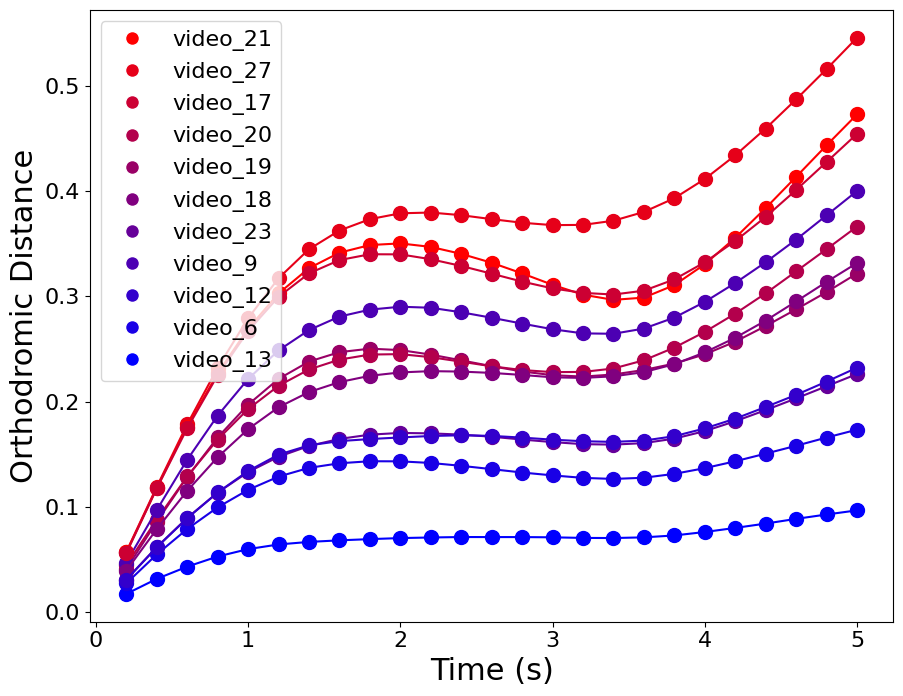

In [146]:
plot_video_charts('Jin_22',markersize=7,fontsize=23)

## Mean AE vs IE 

In [147]:
timestamps = np.arange(0.2, 5.1, 0.2)
def plot_test_entropies(dataset,scale=100,fontsize=22,markersize=80):
    paths=os.path.join(vid_plot_paths,dataset)
    models=os.listdir(paths)
    temp_path=os.path.join(paths,models[0])
    videos=os.listdir(temp_path)
    # Generate unique colors
    num_videos = len(videos)
    colors = generate_unique_colors(num_videos)
    # Create a mapping of videos to colors
    video_colors = dict(zip(videos, colors))
    entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
    video_colors=generate_unique_colors_E(videos,aes)
    
    fig=plot_mean_AEs_vs_entropy(entropies,aes, IEs, dataset, video_colors,scale,fontsize=fontsize)

In [148]:
def plot_mean_AEs_vs_entropy(entropies, aes, ies, dataset, video_colors, scale=100,fontsize=22):
    mean_entropies = []
    mean_AEs = []
    fig, ax = plt.subplots(figsize=(8, 6))
    mean_IEs=[np.mean(ies[video]) for video in ies]
    min_IE = min(mean_IEs)
    max_IE = max(mean_IEs)
    video_data = []  # List to store (video, mean_AE, color)
    for video,color in video_colors.items():
        mean_entropies.append(np.mean(entropies[video]))
        mean_AEs.append(np.mean(aes[video]))
        mean_entropy = np.mean(entropies[video])
        mean_AE = np.mean(aes[video])
        mean_IE=np.mean(ies[video])
        if max_IE != min_IE:  # Avoid division by zero
            marker_size = 1 + 9 * (mean_IE - min_IE) / (max_IE - min_IE)
        else:
            marker_size = 1 
        marker_size=marker_size*scale
        ax.scatter(mean_AE, mean_entropy, color=color, marker='o', label=video,s=marker_size)
        video_data.append((video, mean_AE, color))
        #ax.annotate(video, (mean_AE, mean_entropy), fontsize=8, ha='left', color='black',xytext=offset,textcoords='offset points')
    

    # Create a new figure and axis
    video_data.sort(key=lambda x: x[1], reverse=True)
    plot_dir=os.path.join('Plots','PerVideo_dist')
    os.makedirs(plot_dir, exist_ok=True)
    output_path=os.path.join(plot_dir,f'{dataset}_per_video_ce_ae.png')
    
    #mean_dist_values=
    # Plot the data
    #ax.set_title(f'Test videos {dataset} Mean Entropy vs Mean AE')
    ax.set_xlabel('Mean AE',fontsize=fontsize)
    ax.set_ylabel('Mean SE',fontsize=fontsize)
    handles = [
        plt.Line2D(
            [0], [0], 
            marker='o', 
            color='w', 
            markerfacecolor=color, 
            markersize=10, 
            label=video
        ) 
        for video, _, color in video_data
    ]
    
    ax.legend(handles=handles, fontsize=fontsize-8, title='Videos', title_fontsize=fontsize-7)
    ax.grid(True)
    plt.xticks(fontsize=fontsize-7)
    plt.yticks(fontsize=fontsize-7)
    plt.savefig(output_path)
    
    # Return the figure
    return fig
    #return plt

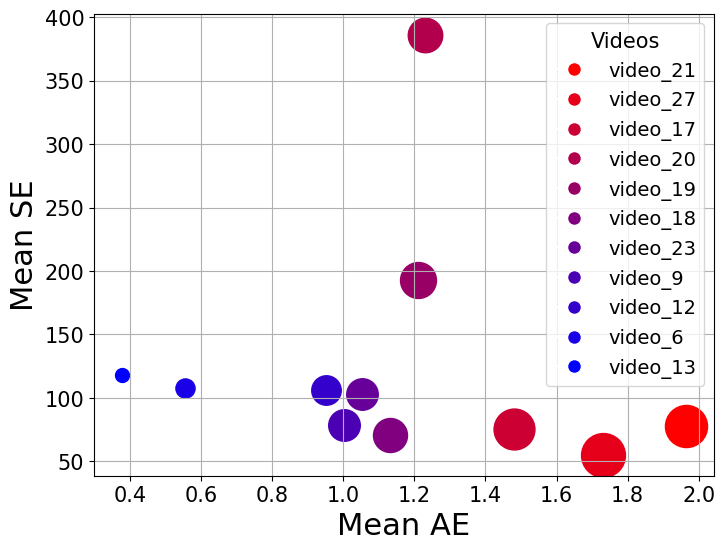

In [149]:
plot_test_entropies('Jin_22',scale=100)

## Full Video Plots over entire video

In [150]:
data_path='Plots/Full_video_plots'
datasets=os.listdir(data_path)

In [151]:
def fetch_user_list(datasets_folder,dataset,videos):
    users={}
    for video in videos:
        data_path=os.path.join(datasets_folder,dataset,'video_data',video)
        users[video]=np.load(os.path.join(data_path,f'{video}_users.npy'))
    return users

In [152]:
def get_user_IE(vid_IEs,vid_users,username):
    user_index = np.where(vid_users == username)[0][0]
    user_IE=vid_IEs[user_index]
    return user_IE

def fetch_timestamps(datasets_folder,dataset,videos):
    tstamps={}
    for video in videos:
        data_path=os.path.join(datasets_folder,dataset,'video_data',video)
        tstamps[video]=np.load(os.path.join(data_path,f'{video}_timestamps.npy'))
    return tstamps

In [153]:
from scipy.signal import find_peaks

In [154]:
from scipy import stats

In [155]:
data_path

'Plots/Full_video_plots'

In [156]:
model_colors

{'pos_only': 'blue',
 'TRACK': 'orange',
 'DVMS_5': 'black',
 'DVMS_2': 'grey',
 'VPT360': 'red',
 'pos_augmented': 'purple',
 'pos_weighted': 'green',
 'AMH': 'brown',
 'ALSTM': 'cyan',
 'ALSTM-E': 'teal'}

In [157]:
models_studied=[
               #'pos_only',
               #'TRACK',
               #'DVMS_5',
               #'DVMS_2',
               #'VPT360',
               #'pos_augmented',
               #'pos_weighted',
               #'AMH',
               'ALSTM',
               'ALSTM-E'
               ]

In [158]:
def plot_individual_performance(data_path,dataset,fontsize=22,markersize=10,shift=10, spec_vid=None, IE=False, models_studied=None):
    models=os.listdir(os.path.join(data_path,dataset))
    model_names=[get_model_name(model) for model in models]
    m_pairs=zip(models,model_names)
    for model, model_name in m_pairs:
        if model_name in models_studied:
            print(model_name)
        else:
            continue
        vid_path=os.path.join(data_path,dataset,model)
        videos=os.listdir(vid_path)
        entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
        #print(IEs['ride'].shape)
        all_users=fetch_user_list(datasets_folder,dataset,videos)
        #print(all_users)
        timestamps=fetch_timestamps(datasets_folder,dataset,videos)
        #print(users)
        #return 0
        if spec_vid:
            videos=[spec_vid]
        for video in videos:
            #video=random.choice(videos)
            user_path=os.path.join(vid_path,video)
            users=os.listdir(user_path)
            #print(user_path)
            #print(users)
            vid_CEs=entropies[video]
            vid_IEs=IEs[video]
            
            vid_users=all_users[video]
            vid_timestamps=timestamps[video]
            user_IEs=0
            all_dist_1=0
            all_dist_2=0
            all_dist_3=0
            all_dist_4=0
            all_dist_5=0
            all_dist_next=0
            #print(len(users))
            for user in users:
                user_IE=get_user_IE(vid_IEs,vid_users,user)
                #print(user_IE[-1])
                user_IEs+=user_IE
                
                result_path=os.path.join(user_path,user)
                dist_next_values=np.load(os.path.join(result_path,'orth_dist_next_values.npy'))
                dist_1_values=np.load(os.path.join(result_path,'orth_dist_1_values.npy'))
                dist_2_values=np.load(os.path.join(result_path,'orth_dist_2_values.npy'))
                dist_3_values=np.load(os.path.join(result_path,'orth_dist_3_values.npy'))
                dist_4_values=np.load(os.path.join(result_path,'orth_dist_4_values.npy'))
                dist_5_values=np.load(os.path.join(result_path,'orth_dist_5_values.npy'))
                all_dist_1+=dist_1_values
                all_dist_2+=dist_2_values
                all_dist_3+=dist_3_values
                all_dist_4+=dist_4_values
                all_dist_5+=dist_5_values
                all_dist_next+=dist_next_values
            dist_next_values=all_dist_next/len(users)
            dist_1_values=all_dist_1/len(users)
            dist_2_values=all_dist_2/len(users)
            dist_3_values=all_dist_3/len(users)
            dist_4_values=all_dist_4/len(users)
            dist_5_values=all_dist_5/len(users)

            mean_IE=user_IEs/len(users)
            timestamps_next=timestamps_next = np.arange(5, 5 + len(dist_next_values) * 1) / 5
            timestamps_1 = np.arange(9, 9 + len(dist_1_values) * 1) / 5  # 1s intervals
            #timestamps_2 = np.arange(14, 14 + len(dist_2_values) * 5, 5) / 5
            timestamps_3 = np.arange(19, 19 + len(dist_3_values) * 1) / 5
            #timestamps_4 = np.arange(24, 24 + len(dist_4_values) * 5, 5) / 5
            timestamps_5 = np.arange(29, 29 + len(dist_5_values) * 1) / 5
            plt.figure(figsize=(14, 8))

            plt.plot(timestamps_5, dist_5_values, marker='o', label='Dist 5 (5s)', color='green')
            plt.legend(loc='upper left', fontsize=fontsize-4)
            plt.xlabel('Time (seconds)', fontsize=fontsize)
            plt.ylabel('Orthodromic Distance', fontsize=fontsize)
            plt.grid(True)
            plt.xticks(fontsize=fontsize-4)
            plt.yticks(fontsize=fontsize-4)
            
            
            #print(user_IEs)
            mean_IE=mean_IE.squeeze()
            #print(mean_IE.shape)
            #print(vid_CEs.shape)
            temp=np.full(shift,np.nan)
            mean_IE=mean_IE[len(mean_IE)-len(timestamps_5):]
            #print(mean_IE.shape)
            #shifted_vid_IEs=np.concatenate([temp,mean_IE])
            #shifted_vid_IEs=shifted_vid_IEs[:len(vid_timestamps)]
            shifted_vid_CEs=np.concatenate([np.full(shift, np.nan), vid_CEs])
            #print(shifted_vid_CEs)
            #shifted_vid_CEs=shifted_vid_CEs[len(shifted_vid_CEs)-len(timestamps_5):]
            shifted_vid_CEs = shifted_vid_CEs[:len(vid_timestamps)]
            fit_CEs=vid_CEs[len(vid_CEs)-len(timestamps_5):]
            # Calculate correlation coefficient and p-value
            correlation_coefficient, p_value = stats.pearsonr(fit_CEs,dist_5_values)
            print("SE Correlation coefficient:", correlation_coefficient)
            print("P-value:", p_value)
            if IE:
                ax3 = plt.gca().twinx()
                ax3.plot(timestamps_5, mean_IE, marker='o', color='blue', label='Instantaneous Entropy')
                ax3.set_ylabel('IE', fontsize=fontsize)
                ax3.tick_params(axis='y', labelcolor='blue')
                ax3.legend(loc='upper right', fontsize=fontsize-4)
            else:
                # Secondary y-axis
                ax2 = plt.gca().twinx()
                ax2.plot(vid_timestamps, shifted_vid_CEs, marker='o', color='red', label='Entropy of Saliency Maps')
                ax2.set_ylabel('SE', fontsize=fontsize)
                ax2.tick_params(axis='y', labelcolor='red')
                ax2.legend(loc='upper right', fontsize=fontsize-4)
            #plt.title(f'Performance Over Time for {model} - {video}', fontsize=fontsize)
            

            correlation_coefficient, p_value = stats.pearsonr(mean_IE,dist_5_values)
            print("IE Correlation coefficient:", correlation_coefficient)
            print("P-value:", p_value)
            # Legends for both axes
            plot_dir=os.path.join('Plots','FullVideo_dist')
            os.makedirs(plot_dir, exist_ok=True)
            if IE:
                output_path=os.path.join(plot_dir,f'{dataset}_{video}_{model_name}_IE.png')
            else:
                output_path=os.path.join(plot_dir,f'{dataset}_{video}_{model_name}.png')
            
            plt.savefig(output_path)
                

ALSTM-E
SE Correlation coefficient: -0.4102505352747937
P-value: 2.4141043837100318e-12
IE Correlation coefficient: 0.14830249536750836
P-value: 0.014912719879583267
ALSTM
SE Correlation coefficient: -0.4029063731890704
P-value: 6.384120625168877e-12
IE Correlation coefficient: 0.2377867121804894
P-value: 8.200355197701933e-05


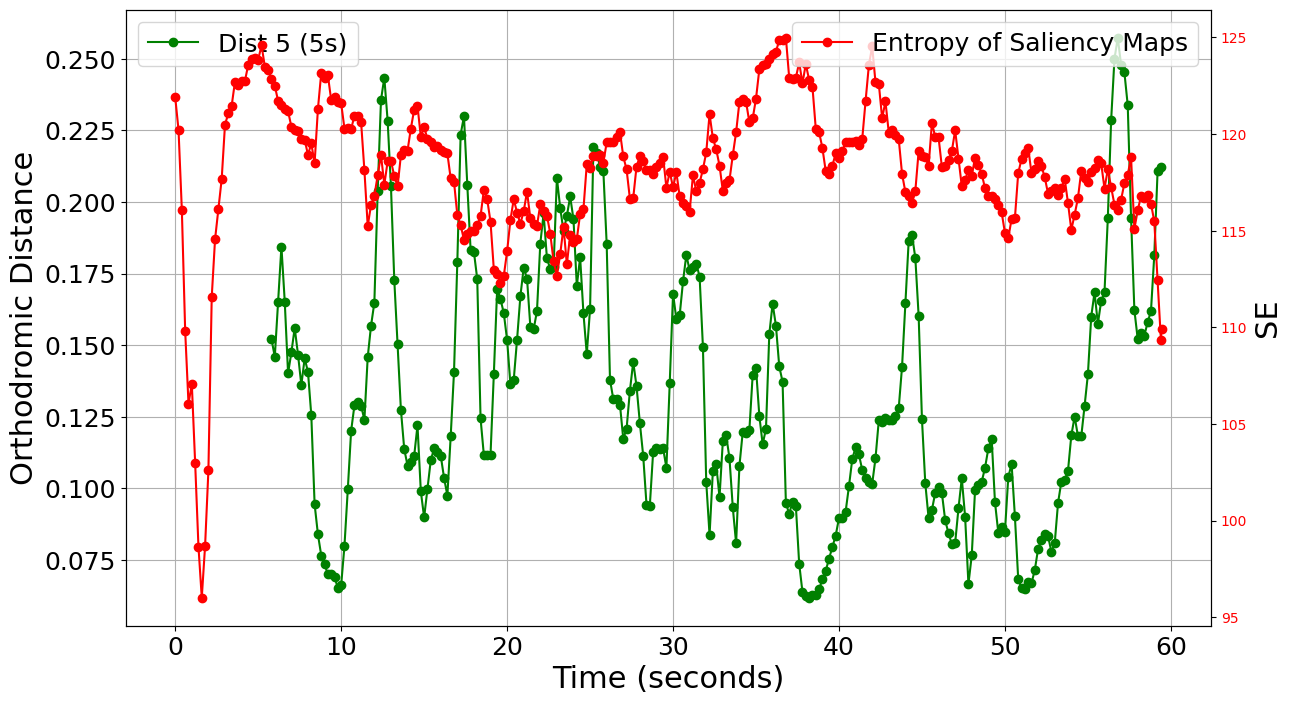

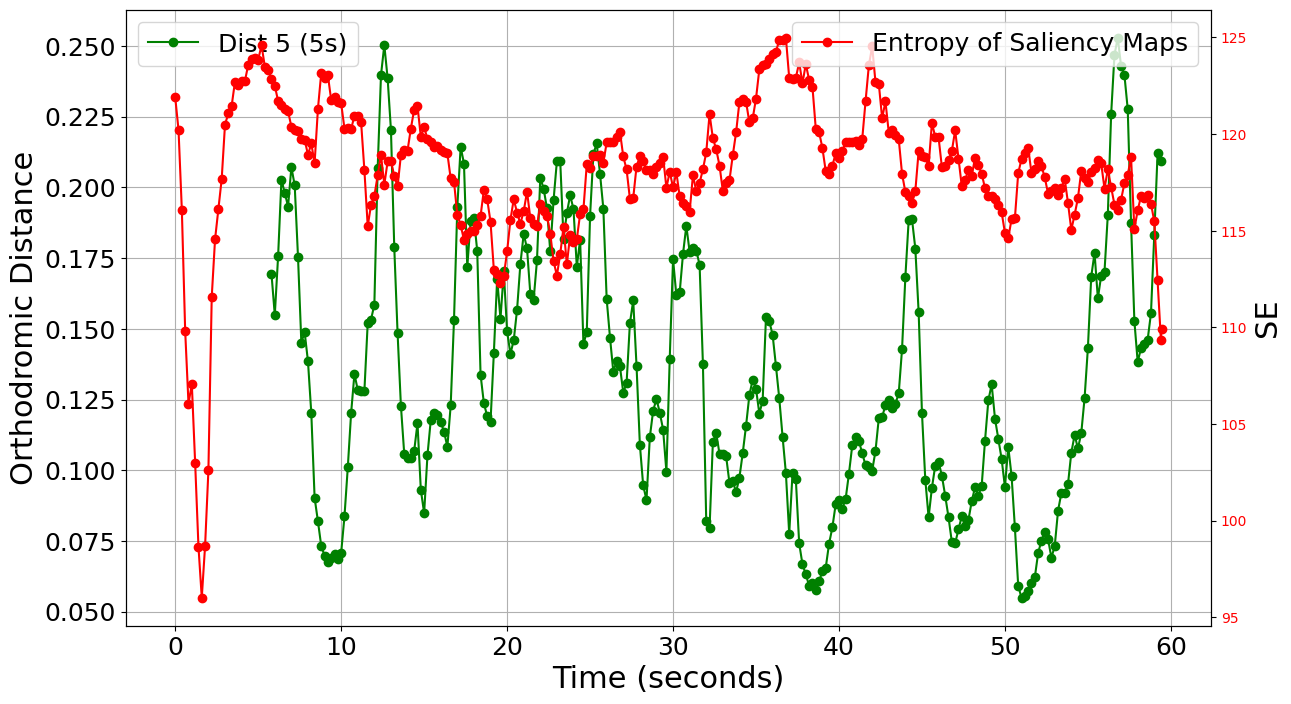

In [159]:
plot_individual_performance(data_path,datasets[2],shift=0, spec_vid='video_13',IE=False, models_studied=models_studied)

## Boxplots

In [194]:
def plot_dist_5_boxplots(data_path, dataset,model_colors, models_studied, fontsize=22):
    # Initialize dictionary to collect dist_5 losses for each model
    dist_5_losses = {model: [] for model in models_studied}

    # Go through each model in the dataset directory
    models = os.listdir(os.path.join(data_path, dataset))
    model_names = [get_model_name(model) for model in models]
    m_pairs = zip(models, model_names)

    for model, model_name in m_pairs:
        if model_name not in models_studied:
            continue

        print(f"Processing model: {model_name}")
        vid_path = os.path.join(data_path, dataset, model)
        videos = os.listdir(vid_path)

        # Collect dist_5 losses for each video-user pair
        for video in videos:
            user_path = os.path.join(vid_path, video)
            users = os.listdir(user_path)

            for user in users:
                result_path = os.path.join(user_path, user)
                
                # Load dist_5 values
                dist_5_values = np.load(os.path.join(result_path, 'orth_dist_5_values.npy'))
                
                # Store losses for boxplot
                dist_5_losses[model_name].extend(dist_5_values)

    # Prepare data for Seaborn
    plot_data = []
    model_labels = []
    colors = []

    for model_name in models_studied:
        if model_name in dist_5_losses:
            plot_data.append(dist_5_losses[model_name])
            model_labels.append(model_name)
            colors.append(model_colors.get(model_name, 'gray'))  # Default to gray if model color is missing

    # Plotting boxplots for dist_5
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=plot_data, palette=colors,whis=2.0,saturation=0.5)
    plt.xticks(range(len(model_labels)), model_labels, fontsize=fontsize)
    plt.ylabel("Loss (Dist_5)", fontsize=fontsize)
    plt.xlabel("Models", fontsize=fontsize)
    plt.title(f"Dist_5 Loss Distribution for {dataset}", fontsize=fontsize)
    plt.grid(True)

    # Save the plot
    plot_dir = os.path.join('Plots', 'Boxplots')
    os.makedirs(plot_dir, exist_ok=True)
    output_path = os.path.join(plot_dir, f"{dataset}_dist_5_loss_boxplot.png")
    plt.savefig(output_path)
    plt.show()
    print(f"Boxplot saved to {output_path}")

Processing model: ALSTM-E
Processing model: ALSTM


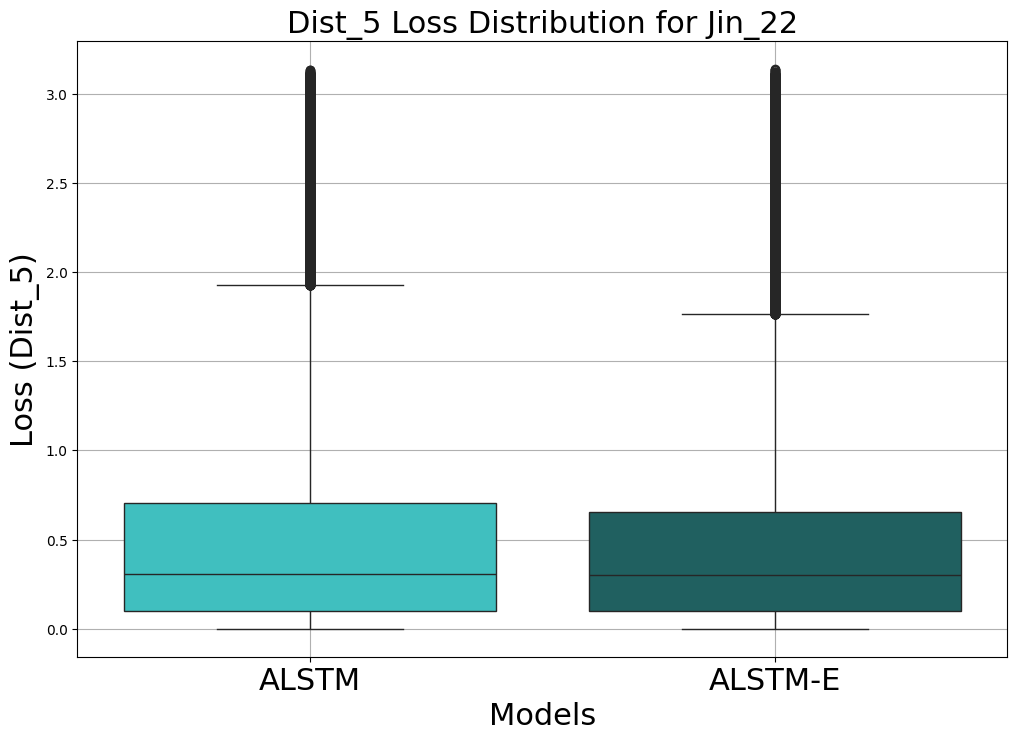

Boxplot saved to Plots/Boxplots/Jin_22_dist_5_loss_boxplot.png


In [195]:
plot_dist_5_boxplots(data_path,datasets[2],model_colors,models_studied=models_studied,fontsize=22)

In [162]:
datasets_folder

'/media/Blue2TB1'

In [163]:
from mpl_toolkits.mplot3d import Axes3D

In [164]:
def plot_traj_xyt(data_folder,dataset,vid_name):
    data_path=os.path.join(data_folder,dataset,'video_data',vid_name)
    saliency_path=os.path.join(data_folder,dataset,'true_saliency')
    saliency=np.load(os.path.join(saliency_path,f'{vid_name}.npy'))
    timestamps=np.load(os.path.join(data_path,f'{vid_name}_timestamps.npy'))
    trajectory=np.load(os.path.join(data_path,f'{vid_name}_unit_vectors.npy'))
    user_idx = np.random.randint(trajectory.shape[0])  # Select a random user (from n users)
    user_trajectory = trajectory[user_idx]
    # Extract x, y, and time (t) from the user trajectory
    x = user_trajectory[:, 0]  # X-coordinate
    y = user_trajectory[:, 1]  # Y-coordinate
    t = timestamps  # Time as the vertical axis

    # Plot the 3D trajectory (x, y, t)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(x, y, t, marker='o', label=f'User {user_idx}', color='b')

    # Add vertical lines at x=0 and y=0
    ax.plot([0, 0], [0, 0], [t.min(), t.max()], color='black', linewidth=2, label='Vertical at (x=0, y=0)')

    # Turn off grid and unnecessary spines
    ax.grid(False)  # Disable grid
    ax.xaxis.pane.fill = False  # Remove background pane for X axis
    ax.yaxis.pane.fill = False  # Remove background pane for Y axis
    ax.zaxis.pane.fill = False  # Remove background pane for Z axis
    ax.xaxis.line.set_color((1, 1, 1, 0))  # Hide x-axis line
    ax.yaxis.line.set_color((1, 1, 1, 0))  # Hide y-axis line
    ax.zaxis.line.set_color((1, 1, 1, 0))  # Hide z-axis line
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Time (seconds)')
    ax.set_title(f'Trajectory of User {user_idx} - {vid_name}')
    
    plt.legend()
    plt.show()

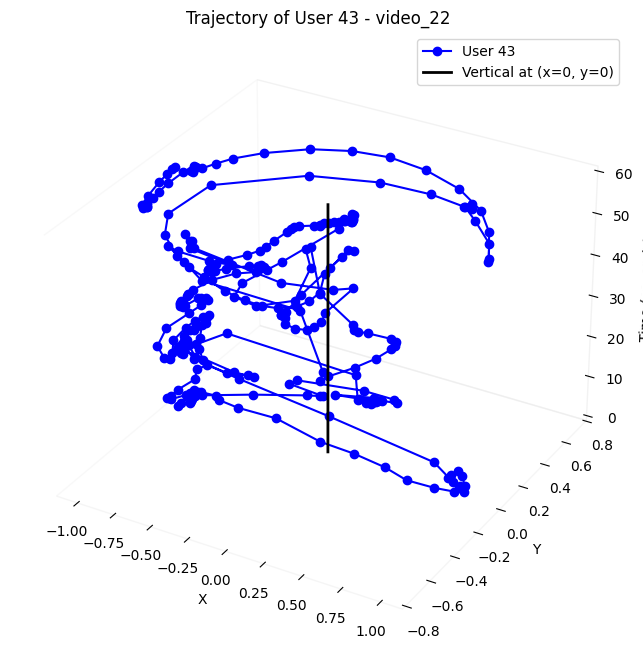

In [165]:
plot_traj_xyt(datasets_folder,'Jin_22', 'video_22')

In [166]:
import plotly.graph_objects as go


In [167]:

def plot_3D_trajectory_with_time(data_folder, dataset, vid_name,fsize=22):
    # Load the data
    data_path = os.path.join(data_folder, dataset, 'video_data', vid_name)
    timestamps = np.load(os.path.join(data_path, f'{vid_name}_timestamps.npy'))
    trajectory = np.load(os.path.join(data_path, f'{vid_name}_unit_vectors.npy'))

    n_users, t, _ = trajectory.shape
    random_users = np.random.choice(n_users, 4, replace=False)  # Select 4 random users
    time_steps = timestamps[:t]
    z_min = min(time_steps)
    z_max = max(time_steps)
    # Plot for each random user
    for user_idx in random_users:
        user_trajectory = trajectory[user_idx, :, :2]  # Get x and y components
        fig = go.Figure()

        fig.add_trace(go.Scatter3d(
            x=user_trajectory[:, 0],
            y=user_trajectory[:, 1],
            z=time_steps,
            mode='lines+markers',
            marker=dict(
                size=4,
                color=time_steps,  # Color based on time
                colorscale='Viridis',
                colorbar=dict(title="Time (s)")
            ),
            #name=f'User {user_idx + 1}',
            line=dict(color='darkblue', width=2),
            showlegend=False
        ))
        fig.add_trace(go.Scatter3d(
            x=[0, 0],  # x-coordinates for the vertical line
            y=[0, 0],  # y-coordinates for the vertical line
            z=[z_min, z_max],  # z-coordinates for the vertical line
            mode='lines',
            line=dict(color='red', width=2, dash='dash'),
            showlegend=False
            #name='Vertical Line at (0, 0)'
        ))

        # Update layout for each plot
        fig.update_layout(
            title=f'User Gaze Trajectory Over Time - {vid_name} (User {user_idx + 1})',
            scene=dict(
                xaxis_title='X Coordinate',
                yaxis_title='Y Coordinate',
                zaxis_title='Time (seconds)',
                xaxis=dict(titlefont=dict(size=fsize)),  # Increase font size for x-axis title
                yaxis=dict(titlefont=dict(size=fsize)),  # Increase font size for y-axis title
                zaxis=dict(titlefont=dict(size=fsize))
            ),
            width=800,
            height=600
        )
        fig.show()

    # Now calculate the average trajectory and variance across all users
    avg_trajectory = np.mean(trajectory[:, :, :2], axis=0)  # Mean across users
    var_trajectory = np.var(trajectory[:, :, :2], axis=0)  # Variance across users (for X and Y components)

    # Plot the average trajectory in 3D
    fig_avg = go.Figure()

    # Plot mean trajectory
    fig_avg.add_trace(go.Scatter3d(
        x=avg_trajectory[:, 0],
        y=avg_trajectory[:, 1],
        z=time_steps,
        mode='lines+markers',
        marker=dict(
            size=4,
            color=time_steps,
            colorscale='Viridis',
            colorbar=dict(title="Time (s)")
        ),
        #name='Average Trajectory',
        line=dict(color='green', width=4),
        showlegend=False
    ))
    fig_avg.add_trace(go.Scatter3d(
            x=[0, 0],  # x-coordinates for the vertical line
            y=[0, 0],  # y-coordinates for the vertical line
            z=[z_min, z_max],  # z-coordinates for the vertical line
            mode='lines',
            line=dict(color='red', width=2, dash='dash'),
            showlegend=False
            #name='Vertical Line at (0, 0)'
        ))
    # Update layout for the average plot
    fig_avg.update_layout(
        #title=f'Average Gaze Trajectory Over Time - {vid_name}',
        scene=dict(
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate',
            zaxis_title='Time (seconds)',
            xaxis=dict(titlefont=dict(size=fsize)),  # Increase font size for x-axis title
            yaxis=dict(titlefont=dict(size=fsize)),  # Increase font size for y-axis title
            zaxis=dict(titlefont=dict(size=fsize))
        ),
        width=800,
        height=600
    )
    fig_avg.show()
    fig_avg.write_html(f'average_trajectory_{vid_name}.html')
    fig_avg.show()
    # Plot 2D variance with respect to time
    variance_x = var_trajectory[:, 0]  # Variance for X component over time
    variance_y = var_trajectory[:, 1]  # Variance for Y component over time

    # Create a 2D variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, variance_x, label='Variance in X', color='red', marker='o')
    plt.plot(time_steps, variance_y, label='Variance in Y', color='blue', marker='o')

    # Plot formatting
    #plt.title(f'Variance in Trajectory Over Time - {vid_name}', fontsize=14)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Show the variance plot
    plt.show()

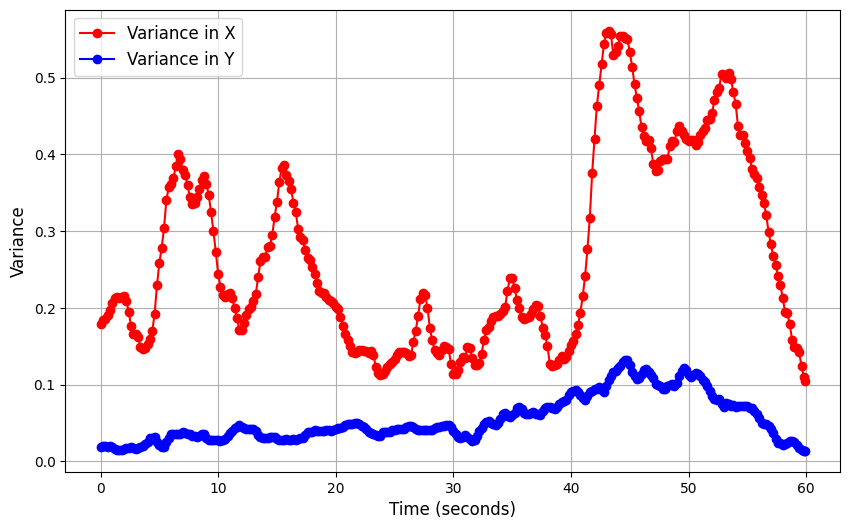

In [168]:
plot_3D_trajectory_with_time(datasets_folder,'Jin_22', 'video_22',fsize=22)

In [169]:
def plot_3D_2d_trajectory_with_time(data_folder, dataset, vid_name, fsize=22):
    # Load the data
    data_path = os.path.join(data_folder, dataset, 'video_data', vid_name)
    timestamps = np.load(os.path.join(data_path, f'{vid_name}_timestamps.npy'))
    trajectory = np.load(os.path.join(data_path, f'{vid_name}_unit_vectors.npy'))

    n_users, t, _ = trajectory.shape
    random_users = np.random.choice(n_users, 4, replace=False)  # Select 4 random users
    time_steps = timestamps[:t]
    z_min = min(time_steps)
    z_max = max(time_steps)

    # Plot for each random user
    for user_idx in random_users:
        user_trajectory = trajectory[user_idx, :, :2]  # Get x and y components
        fig = go.Figure()

        fig.add_trace(go.Scatter3d(
            x=user_trajectory[:, 0],
            y=user_trajectory[:, 1],
            z=time_steps,
            mode='lines+markers',
            marker=dict(
                size=4,
                color=time_steps,  # Color based on time
                colorscale='Viridis',
                colorbar=dict(title="Time (s)")
            ),
            line=dict(color='darkblue', width=2),
            showlegend=False
        ))
        fig.add_trace(go.Scatter3d(
            x=[0, 0],  # x-coordinates for the vertical line
            y=[0, 0],  # y-coordinates for the vertical line
            z=[z_min, z_max],  # z-coordinates for the vertical line
            mode='lines',
            line=dict(color='red', width=2, dash='dash'),
            showlegend=False
        ))

        # Update layout for each plot
        fig.update_layout(
            title=f'User Gaze Trajectory Over Time - {vid_name} (User {user_idx + 1})',
            scene=dict(
                xaxis_title='X Coordinate',
                yaxis_title='Y Coordinate',
                zaxis_title='Time (seconds)',
                xaxis=dict(titlefont=dict(size=fsize)),  # Increase font size for x-axis title
                yaxis=dict(titlefont=dict(size=fsize)),  # Increase font size for y-axis title
                zaxis=dict(titlefont=dict(size=fsize))
            ),
            width=800,
            height=600
        )
        fig.show()

    # Now calculate the average trajectory and variance across all users
    avg_trajectory = np.mean(trajectory[:, :, :2], axis=0)  # Mean across users

    # Plot the average trajectory in 2D using Plotly
    fig_avg = go.Figure()

    # Add 2D scatter plot with color mapping for time
    fig_avg.add_trace(go.Scatter(
        x=avg_trajectory[:, 0],
        y=avg_trajectory[:, 1],
        mode='lines+markers',
        marker=dict(
            size=8,
            color=time_steps,
            colorscale='Viridis',
            colorbar=dict(title="Time (s)")
        ),
        line=dict(color='green', width=4),
        showlegend=False
    ))

    # Update layout for the average plot
    fig_avg.update_layout(
        title=f'Average Gaze Trajectory Over Time (2D) - {vid_name}',
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        width=800,
        height=600
    )

    # Show the 2D plot in Plotly
    fig_avg.show()

    # Plot 2D variance with respect to time
    var_trajectory = np.var(trajectory[:, :, :2], axis=0)  # Variance across users (for X and Y components)
    variance_x = var_trajectory[:, 0]  # Variance for X component over time
    variance_y = var_trajectory[:, 1]  # Variance for Y component over time

    # Create a 2D variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, variance_x, label='Variance in X', color='red', marker='o')
    plt.plot(time_steps, variance_y, label='Variance in Y', color='blue', marker='o')

    # Plot formatting
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Show the variance plot
    plt.show()

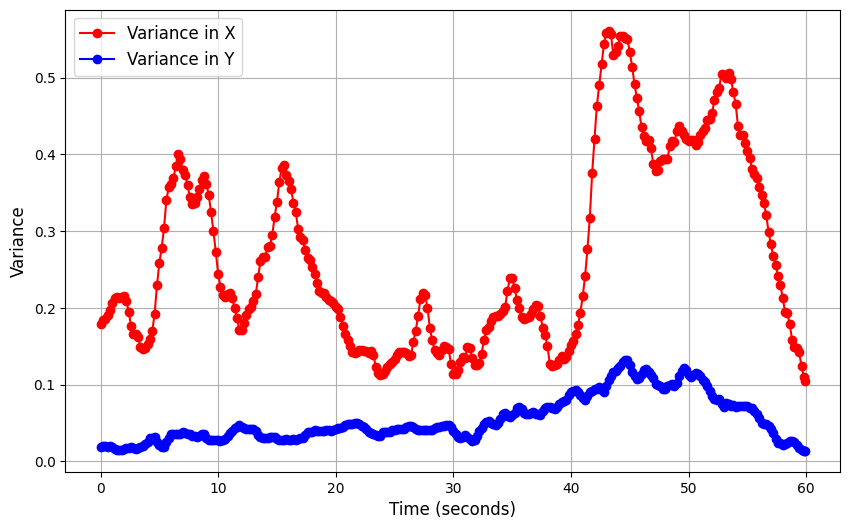

In [170]:
plot_3D_2d_trajectory_with_time(datasets_folder,'Jin_22', 'video_22',fsize=22)

In [171]:

def plot_2D_trajectory_with_time(data_folder, dataset, vid_name, fsize=22):
    # Load the data
    data_path = os.path.join(data_folder, dataset, 'video_data', vid_name)
    timestamps = np.load(os.path.join(data_path, f'{vid_name}_timestamps.npy'))
    trajectory = np.load(os.path.join(data_path, f'{vid_name}_unit_vectors.npy'))

    n_users, t, _ = trajectory.shape
    random_users = np.random.choice(n_users, 4, replace=False)  # Select 4 random users
    time_steps = timestamps[:t]

    # Plot for each random user in 2D
    for user_idx in random_users:
        user_trajectory = trajectory[user_idx, :, :2]  # Get x and y components (2D)

        fig = go.Figure()

        # 2D scatter plot with color gradient representing time
        fig.add_trace(go.Scatter(
            x=user_trajectory[:, 0],
            y=user_trajectory[:, 1],
            mode='lines+markers',
            marker=dict(
                size=6,
                color=time_steps,  # Color based on time
                colorscale='Viridis',
                colorbar=dict(title="Time (s)"),
            ),
            line=dict(color='darkblue', width=2),
            showlegend=False
        ))

        # Update layout for 2D plot
        fig.update_layout(
            title=f'User Gaze Trajectory Over Time - {vid_name} (User {user_idx + 1})',
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate',
            font=dict(size=fsize),
            width=800,
            height=600
        )
        fig.show()

    # Now calculate the average trajectory and variance across all users
    avg_trajectory = np.mean(trajectory[:, :, :2], axis=0)  # Mean across users
    var_trajectory = np.var(trajectory[:, :, :2], axis=0)  # Variance across users (for X and Y components)
    std_trajectory = np.sqrt(var_trajectory)  # Standard deviation (sqrt of variance)
    # Plot the average trajectory in 2D
    fig_avg = go.Figure()

    # Plot mean trajectory
    fig_avg.add_trace(go.Scatter(
        x=avg_trajectory[:, 0],
        y=avg_trajectory[:, 1],
        mode='lines+markers',
        marker=dict(
            size=6,
            color=time_steps,
            colorscale='Viridis',
            colorbar=dict(title="Time (s)")
        ),
        line=dict(color='green', width=4),
        showlegend=False
    ))

    # Update layout for the average trajectory plot
    fig_avg.update_layout(
        title=f'Average Gaze Trajectory Over Time - {vid_name}',
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        font=dict(size=fsize),
        width=800,
        height=600
    )
    fig_avg.show()
    #fig_avg.write_html(f'average_trajectory_{vid_name}.html')

    # Plot X vs Time for the average trajectory
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, avg_trajectory[:, 0], label='Average X vs Time', color='green', marker='o')
    # Plot formatting
    plt.title(f'Average X Coordinate vs Time - {vid_name}', fontsize=14)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Average X Coordinate', fontsize=12)
    #plt.legend(fontsize=12)
    plt.grid(True)
    output_dest='Plots/2d_trajectory'
    plt.savefig(os.path.join(output_dest,f'{dataset}_{vid_name}_averageX_over_time.png'))
    # Show the X vs Time plot
    plt.show()

In [172]:
def var_norm(data, epsilon=1e-5):
    return np.var(data)/max(np.mean(data),epsilon)

from sklearn.model_selection import train_test_split

In [173]:
def split_videos(dataset_dir, bins=2, video_test_size=0.4):
    data_dir = os.path.join(dataset_dir, 'video_data')
    videos = os.listdir(data_dir)
    AE = {}
    SI = {}
    TI = {}
    CE = {}

    for video in videos:
        vid_path = os.path.join(data_dir, video)
        siti_path = os.path.join(data_dir, video)
        AE[video] = np.load(os.path.join(vid_path, f'{video}_AEs.npy'))
        AE[video] = np.mean(AE[video])
        CE[video] = np.load(os.path.join(vid_path, f'{video}_content_entropy.npy'))
        CE[video] = np.mean(CE[video])
        SI[video] = np.load(os.path.join(siti_path, f'{video}_SI.npy'))
        SI[video] = np.mean(SI[video])
        TI[video] = np.load(os.path.join(siti_path, f'{video}_TI.npy'))
        TI[video] = np.mean(TI[video])

    # Calculate bin edges and print them
    ae_bins, ae_bin_edges = pd.qcut(list(AE.values()), q=bins, labels=False, retbins=True)
    ce_bins, ce_bin_edges = pd.qcut(list(CE.values()), q=bins, labels=False, retbins=True)
    si_bins, si_bin_edges = pd.qcut(list(SI.values()), q=bins, labels=False, retbins=True)
    ti_bins, ti_bin_edges = pd.qcut(list(TI.values()), q=bins, labels=False, retbins=True)

    # Print the bin edges for each feature
    print(f"AE bin edges: {ae_bin_edges}")
    print(f"CE bin edges: {ce_bin_edges}")
    print(f"SI bin edges: {si_bin_edges}")
    print(f"TI bin edges: {ti_bin_edges}")

    strat_keys = [f"{ae}_{ce}" for ae, ce in zip(ae_bins, ce_bins)]

    try:
        train_videos, test_videos = train_test_split(videos, test_size=video_test_size, stratify=strat_keys)
    except ValueError:
        print("Can't use combined stratified key")
        ae_variance = var_norm(list(AE.values()))
        ce_variance = var_norm(list(CE.values()))
        if ae_variance > ce_variance:
            strat_keys = ae_bins
            print("Using AE for stratification")
        else:
            strat_keys = ce_bins
            print("Using CE for stratification")

        try:
            train_videos, test_videos = train_test_split(videos, test_size=video_test_size, stratify=strat_keys)
        except ValueError:
            print("Can't use stratified keys, using random split instead.")
            train_videos, test_videos = train_test_split(videos, test_size=video_test_size)

    return train_videos, test_videos

In [174]:
datasets

['PAMI18', 'Fan_NOSSDAV_17', 'Jin_22']

In [175]:
root_folder='/media/Blue2TB1'
root_dataset_folder = os.path.join('/media/Blue2TB1', 'Jin_22')
#split_videos(root_dataset_folder)

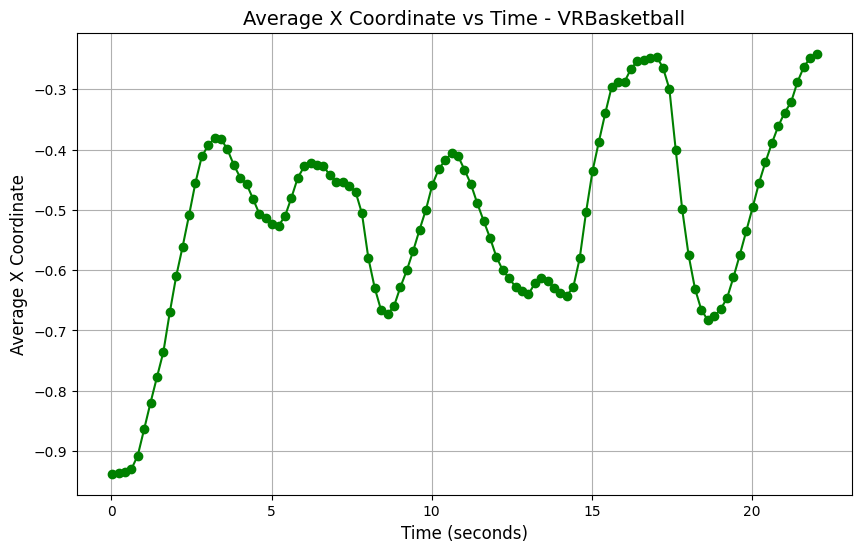

In [176]:
plot_2D_trajectory_with_time(datasets_folder,'PAMI18', 'VRBasketball',fsize=22)

In [177]:
def store_instant_vel(data_folder, dataset):
    data_path=os.path.join(data_folder, dataset,'video_data')
    videos=os.listdir(data_path)
    for video in videos:
        unit_vectors=np.load(os.path.join(data_path,video,f'{video}_unit_vectors.npy'))
        print(unit_vectors.shape)
        ivs=np.diff(unit_vectors,axis=1)
        ivs=np.linalg.norm(ivs, axis=2)
        zeros=np.zeros((ivs.shape[0],1))
        ivs=np.concatenate((zeros,ivs),axis=1)
        #np.save(os.path.join(data_path,video, f'{video}_instantaneous_velocities.npy'), ivs)

In [178]:
store_instant_vel(datasets_folder,'Jin_22')

(99, 301, 3)
(99, 301, 3)
(99, 292, 3)
(99, 292, 3)
(99, 295, 3)
(99, 292, 3)
(99, 300, 3)
(99, 300, 3)
(99, 293, 3)
(100, 301, 3)
(100, 294, 3)
(100, 295, 3)
(100, 299, 3)
(99, 295, 3)
(97, 301, 3)
(98, 291, 3)
(96, 291, 3)
(96, 286, 3)
(96, 301, 3)
(96, 301, 3)
(96, 296, 3)
(96, 301, 3)
(95, 301, 3)
(94, 292, 3)
(94, 292, 3)
(92, 292, 3)
(92, 283, 3)


In [179]:
def fetch_ivs(datasets_folder,dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    #video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(data_path)
    IVs={}
    for video in videos:
        iv_path = os.path.join(data_path, video, f'{video}_instantaneous_velocities.npy')
        iv=np.load(iv_path)
        IVs[video]=iv
    return IVs

In [180]:
IVs=fetch_ivs(datasets_folder,'Jin_22')

In [181]:
def get_test_IVs(datasets_folder,dataset):
    IVs=fetch_ivs(datasets_folder,dataset)
    paths=os.path.join(vid_plot_paths,dataset)
    models=os.listdir(paths)
    models=['DVMS__init_5_in_5_out_25_end_25_K5_Epoch500']
    temp_path=os.path.join(paths,models[0])
    output_path=os.path.join('Plots','PerVideo_test')
    os.makedirs(output_path, exist_ok=True)
    videos=os.listdir(temp_path)
    return {video: IVs[video] for video in videos if video in IVs}

In [182]:
test_IVs=get_test_IVs(datasets_folder,'Jin_22')

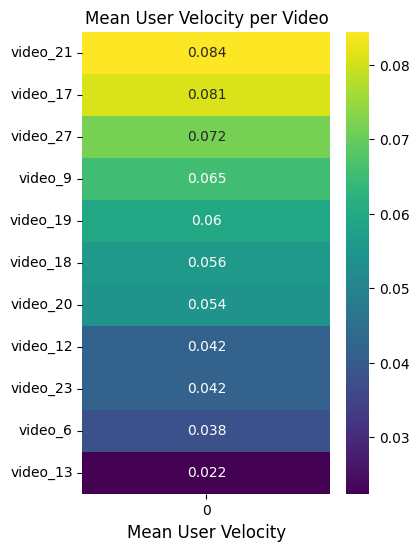

In [183]:
# Calculate mean velocity per video
mean_velocities = {video: test_IVs[video].mean() for video in test_IVs}

# Create a sorted array of mean velocities
sorted_mean_velocities = sorted(mean_velocities.items(), key=lambda x: x[1], reverse=True)
video_labels, velocity_values = zip(*sorted_mean_velocities)

# Plot heatmap
plt.figure(figsize=(4, 6))
sns.heatmap(np.array(velocity_values).reshape(-1, 1), annot=True, yticklabels=video_labels, cmap="viridis", annot_kws={"size": 10})
plt.xlabel('Mean User Velocity', fontsize=12)
plt.title('Mean User Velocity per Video',fontsize=12)
plt.show()

In [184]:
def plot_mean_AEs_vs_mean_velocity_datasets(datasets_folder,datasets,color,dataset_names,fontsize=12,markersize=50):
    global_min_AE, global_max_AE = float('inf'), float('-inf')
    global_min_iv, global_max_iv = float('inf'), float('-inf')
    video_AEs={}
    video_IVs={}
    for idx,dataset in enumerate(datasets):
        ces,aes,_=fetch_entropies(datasets_folder,dataset)
        IVs=fetch_ivs(datasets_folder,dataset)
        mean_IVs = []
        mean_AEs = []
        for video in ces:
            if np.mean(ces[video])>150:
                continue
            mean_CE=np.mean(ces[video])
            mean_AE=np.mean(aes[video])
            global_min_AE = min(global_min_AE, mean_AE)
            global_max_AE = max(global_max_AE, mean_AE)
            global_min_CE = min(global_min_CE, mean_CE)
            global_max_CE = max(global_max_CE, mean_CE)
            mean_CEs.append(mean_CE)
            mean_AEs.append(mean_AE)
        video_AEs[dataset]=mean_AEs
        video_CEs[dataset]=mean_CEs
    
    plt.figure(figsize=(8, 6))
    for idx, dataset in enumerate(datasets):
        
        
        plt.scatter(video_AEs[dataset], video_CEs[dataset], color=color[idx], marker='o',label=dataset_names[idx],s=markersize)
        #for i, video in enumerate(entropies):
        #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean AEs',fontsize=fontsize)
    plt.ylabel('Mean Content Entropy', fontsize=fontsize)
    plt.ylim(global_min_CE-2, global_max_CE+2)
    plt.xlim(global_min_AE-0.1, global_max_AE + 0.1)
    plt.xticks(fontsize=fontsize-4)
    plt.yticks(fontsize=fontsize-4)
    plt.legend()
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Entropies')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'all_datasets_contententropy_vs_AE.png')
    plt.savefig(plot_path)
    plt.show()
    


In [185]:
def plot_mean_AEs_vs_iv(ivs, aes,dataset,color='blue',fontsize=12,markersize=50):
    mean_ivs = []
    mean_AEs = []
    videos=list(ivs.keys())
    for video in ivs:
        #if np.mean(entropies[video])>200:
            #continue
        mean_ivs.append(np.mean(ivs[video]))
        mean_AEs.append(np.mean(aes[video]))
        
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_AEs, mean_ivs, color=color, marker='o',s=markersize)
    for i, video in enumerate(videos):
        plt.annotate(video, (mean_AEs[i], mean_ivs[i]), fontsize=fontsize-6, ha='right', va='bottom')
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean Actual Entropy',fontsize=fontsize)
    plt.ylabel('Mean instantaneous velocity',fontsize=fontsize)
    plt.xticks(fontsize=fontsize-7)
    plt.yticks(fontsize=fontsize-7)
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Entropies')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_actualentropy_vs_IV.png')
    plt.savefig(plot_path)
    plt.show()

In [186]:
def fetch_entropies2(datasets_folder,dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(data_path)
    entropies={}
    aes={}
    IEs={}
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        ae_path=os.path.join(data_path,video, f'{video}_AEs.npy')
        IE_path=os.path.join(data_path, video, f'{video}_IEs.npy')
        entropy=np.load(entropy_path)
        ae=np.load(ae_path)
        ie=np.load(IE_path)
        entropies[video]=entropy
        aes[video]=ae
        IEs[video]=ie
    return entropies,aes,IEs

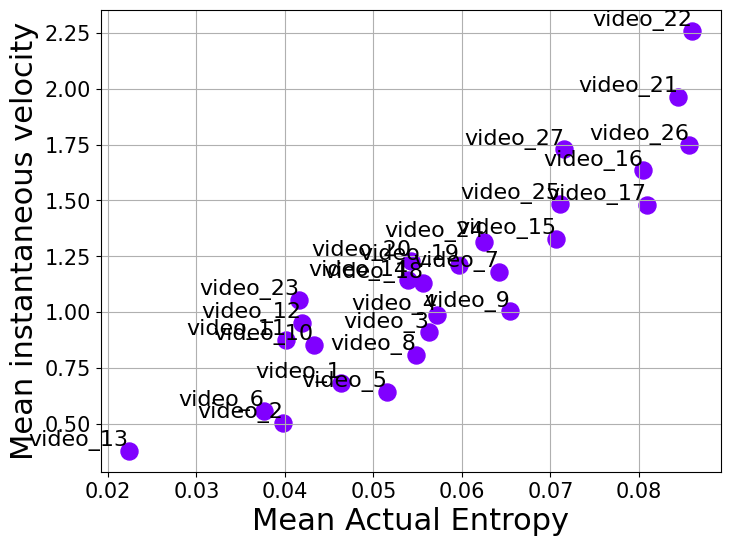

In [187]:
dataset='Jin_22'
c_entropies,aes,IEs=fetch_entropies2(datasets_folder,dataset)
ivs=fetch_ivs(datasets_folder,dataset)
plot_mean_AEs_vs_iv(aes, ivs, dataset,color=dataset_colors[idx],fontsize=22,markersize=150)

In [188]:
""" def create_saliency_video(data_folder, dataset, vid_name, output_folder):
    # Load the saliency map
    saliency_path = os.path.join(data_folder, dataset, 'true_saliency')
    saliency_maps = np.load(os.path.join(saliency_path, f'{vid_name}.npy'))  # Shape: (t, 256, 256)

    # Set up video parameters
    height, width = saliency_maps.shape[1], saliency_maps.shape[2]
    fps = 5
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4

    # Create a VideoWriter object
    output_path=os.path.join(output_folder,f'saliency_{vid_name}.mp4')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Write each saliency map to the video
    for frame in saliency_maps:
        # Normalize saliency map to the range 0-255 for proper video encoding
        normalized_frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        # Convert to color (if needed)
        colored_frame = cv2.applyColorMap(normalized_frame, cv2.COLORMAP_JET)  # Apply a colormap
        
        out.write(colored_frame)  # Write frame to video

    # Release the video writer
    out.release()
    print(f'Video saved at {output_path}') """

" def create_saliency_video(data_folder, dataset, vid_name, output_folder):\n    # Load the saliency map\n    saliency_path = os.path.join(data_folder, dataset, 'true_saliency')\n    saliency_maps = np.load(os.path.join(saliency_path, f'{vid_name}.npy'))  # Shape: (t, 256, 256)\n\n    # Set up video parameters\n    height, width = saliency_maps.shape[1], saliency_maps.shape[2]\n    fps = 5\n    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4\n\n    # Create a VideoWriter object\n    output_path=os.path.join(output_folder,f'saliency_{vid_name}.mp4')\n    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))\n\n    # Write each saliency map to the video\n    for frame in saliency_maps:\n        # Normalize saliency map to the range 0-255 for proper video encoding\n        normalized_frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)\n        # Convert to color (if needed)\n        colored_frame = cv2.applyColorMap(normalized_frame, cv2.COLO

In [189]:
#create_saliency_video(datasets_folder,'Jin_22','video_27','saliency_videos')